#Fashion MNIST Dataset

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms

import torchvision

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 3.5 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20
Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=600971191343250bda2504368b9533e6234ba9cada980728a9d4209f2d4a3b4f
  Stored in directory: /root/.cache/pip/wh

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [3]:
#Load the MNIST dataset
dataset='FMNIST'
plot_dataset='FMNIST'


#Import the MNIST Dataset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([32,32])
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



# Reduce training and test datasets
reduced_train_dataset, valid_dataset = utilsTFG.reduce_dataset(train_dataset, 10000, 0.7, balance=True)
reduced_test_dataset = utilsTFG.reduce_dataset(test_dataset, 5000)



In [4]:

print("Training set class distribution:")
utilsTFG.verify_class_balance(reduced_train_dataset)

print("Validation set class distribution:")
utilsTFG.verify_class_balance(valid_dataset)

print("\nTest set class distribution:")
utilsTFG.verify_class_balance(reduced_test_dataset)

Training set class distribution:
Class 0: 700 samples
Class 1: 700 samples
Class 2: 700 samples
Class 3: 700 samples
Class 4: 700 samples
Class 5: 700 samples
Class 6: 700 samples
Class 7: 700 samples
Class 8: 700 samples
Class 9: 700 samples
Validation set class distribution:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 300 samples
Class 6: 300 samples
Class 7: 300 samples
Class 8: 300 samples
Class 9: 300 samples

Test set class distribution:
Class 0: 500 samples
Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 4: 500 samples
Class 5: 500 samples
Class 6: 500 samples
Class 7: 500 samples
Class 8: 500 samples
Class 9: 500 samples


In [5]:
from torch.utils.data import DataLoader, random_split


# Define batch size
batch_size = 512

# Create DataLoader objects
train_loader = DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=False)

# Check the size of each DataLoader
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(validation_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 7000
Validation set size: 3000
Test set size: 7000


In [6]:
import copy
dls = DataLoaders.from_dsets(reduced_train_dataset, valid_dataset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)
dls.to(device)
test_dl.to(device)

models =['LeNet5', 'ResNet15', 'ResNet57']
mod = [utilsTFG.LeNet5(), utilsTFG.ResNet15(num_classes=10), utilsTFG.ResNet57(num_classes=10)]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['accuracy']

init_weights = {}
for model, m in zip(models, mod):
  learn = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[model] = utilsTFG.get_params_from_model(learn.model)
  print(learn.summary())

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


LeNet5 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 6 x 28 x 28   
Conv2d                                    156        True      
BatchNorm2d                               12         True      
____________________________________________________________________________
                     512 x 16 x 5 x 5    
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 10 x 10  
Conv2d                                    2416       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 120           
Linear                                    48120      True      
BatchNorm1d                               240        True      
_________________________________________________

ResNet15 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
Conv2d                                    1024 

ResNet57 (Input shape: 512 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     512 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     512 x 64 x 13 x 13  
Conv2d                                    1024 

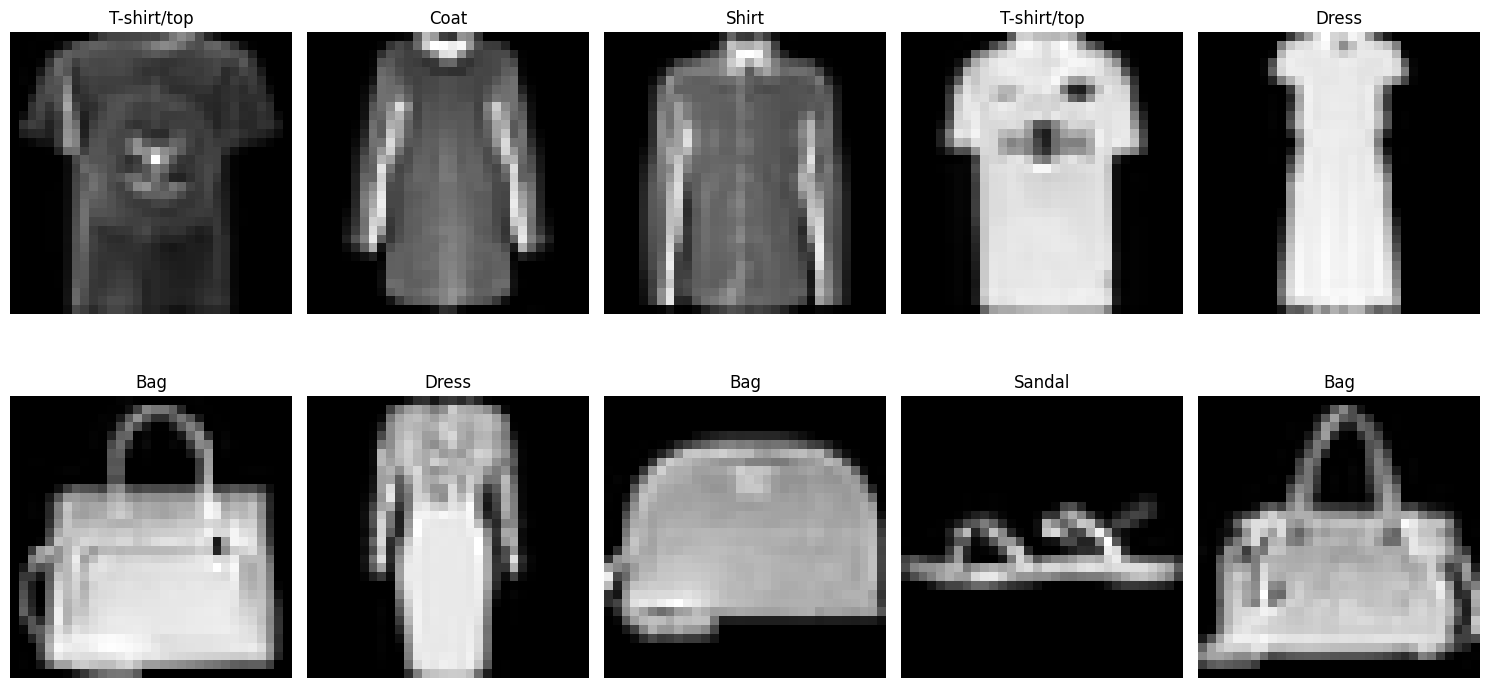

In [7]:
# Get a batch of images and labels
batch = dls.one_batch()

# Number of images to display
num_images = 10

# Create a figure with a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Plot each image in the grid
for i in range(num_images):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    img = batch[0][i].cpu().squeeze().numpy()
    label = class_names[batch[1][i].item()]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

## Gradient Descent

In [8]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for model, m in zip(models,mod):
        learners[opt][model] = Learner(dls=dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][model].to(device)
        learners[opt][model].model.to(device)
        utilsTFG.set_params_to_model(init_weights[model], learners[opt][model].model)


In [9]:
#To check if the models have the same initial parameters
for model in models:
  if utilsTFG.compare_models(learners['NAG'][model], learners['RMSProp'][model]) and utilsTFG.compare_models(learners['NAG'][model], learners['ADAM'][model]) and utilsTFG.compare_models(learners['ADAM'][model], learners['RMSProp'][model]):
    print(f"Mismos parámetros con el modelo {model}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros con el modelo LeNet5.
Mismos parámetros con el modelo ResNet15.
Mismos parámetros con el modelo ResNet57.


### Nesterov

Better model found at epoch 0 with valid_loss value: 2.350355386734009.
Better model found at epoch 1 with valid_loss value: 1.7518386840820312.
Better model found at epoch 2 with valid_loss value: 1.1461330652236938.
Better model found at epoch 3 with valid_loss value: 0.9228060841560364.
Better model found at epoch 4 with valid_loss value: 0.8286967873573303.
Better model found at epoch 5 with valid_loss value: 0.7744672894477844.
Better model found at epoch 6 with valid_loss value: 0.7377327680587769.
Better model found at epoch 7 with valid_loss value: 0.7051189541816711.
Better model found at epoch 8 with valid_loss value: 0.6811988949775696.
Better model found at epoch 9 with valid_loss value: 0.6633303761482239.
Better model found at epoch 10 with valid_loss value: 0.6461019515991211.
Better model found at epoch 11 with valid_loss value: 0.6332015991210938.
Better model found at epoch 12 with valid_loss value: 0.6224307417869568.
Better model found at epoch 13 with valid_loss va

Better model found at epoch 0 with valid_loss value: 2.445712089538574.
Better model found at epoch 3 with valid_loss value: 1.9582374095916748.
Better model found at epoch 4 with valid_loss value: 1.181896686553955.
Better model found at epoch 5 with valid_loss value: 0.8022892475128174.
Better model found at epoch 6 with valid_loss value: 0.6268721222877502.
Better model found at epoch 7 with valid_loss value: 0.5887799263000488.
Better model found at epoch 9 with valid_loss value: 0.5434131026268005.
Better model found at epoch 10 with valid_loss value: 0.5252472162246704.
Better model found at epoch 11 with valid_loss value: 0.5222284197807312.
Better model found at epoch 12 with valid_loss value: 0.5155798196792603.
Better model found at epoch 13 with valid_loss value: 0.503068745136261.
Better model found at epoch 14 with valid_loss value: 0.490397185087204.
Better model found at epoch 15 with valid_loss value: 0.4883056581020355.
Better model found at epoch 16 with valid_loss va

Better model found at epoch 0 with valid_loss value: 2.6434497833251953.
Better model found at epoch 2 with valid_loss value: 2.5432815551757812.
Better model found at epoch 3 with valid_loss value: 1.3693541288375854.
Better model found at epoch 4 with valid_loss value: 1.022094488143921.
Better model found at epoch 5 with valid_loss value: 0.8639310002326965.
Better model found at epoch 6 with valid_loss value: 0.7898165583610535.
Better model found at epoch 7 with valid_loss value: 0.7443925142288208.
Better model found at epoch 8 with valid_loss value: 0.7009744644165039.
Better model found at epoch 9 with valid_loss value: 0.6688161492347717.
Better model found at epoch 10 with valid_loss value: 0.6537542939186096.
Better model found at epoch 11 with valid_loss value: 0.6406967639923096.
Better model found at epoch 12 with valid_loss value: 0.6281493902206421.
Better model found at epoch 13 with valid_loss value: 0.6171415448188782.
Better model found at epoch 14 with valid_loss v

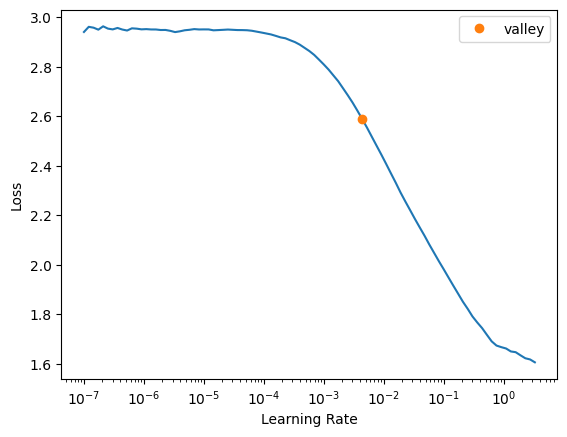

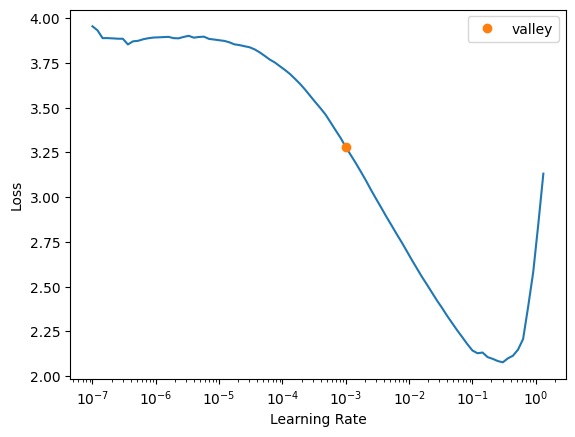

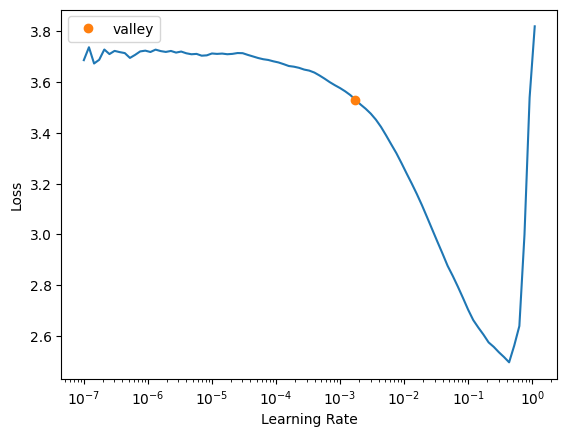

In [9]:
#Run the training and measure the time for each layer
for model, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][model] = end-start



<Figure size 1200x600 with 0 Axes>

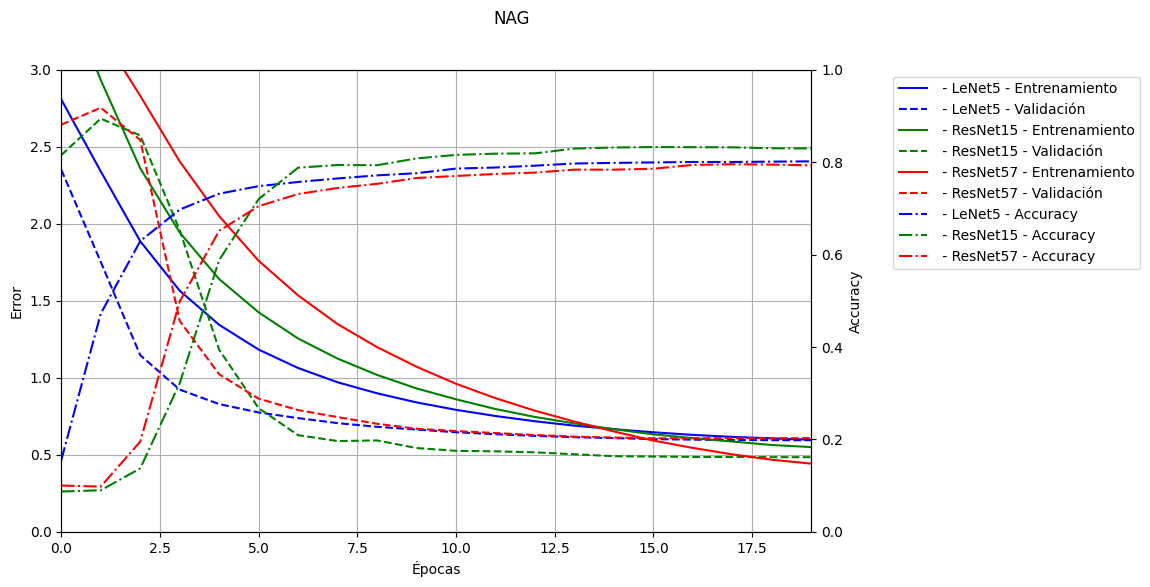

In [25]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), lim=3, title='NAG', names=models, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 1.3651299476623535.
Better model found at epoch 1 with valid_loss value: 0.7639837265014648.
Better model found at epoch 2 with valid_loss value: 0.663724422454834.
Better model found at epoch 3 with valid_loss value: 0.5232714414596558.
Better model found at epoch 4 with valid_loss value: 0.45998233556747437.
Better model found at epoch 6 with valid_loss value: 0.4182735085487366.
Better model found at epoch 7 with valid_loss value: 0.415668785572052.
Better model found at epoch 8 with valid_loss value: 0.41016486287117004.
Better model found at epoch 9 with valid_loss value: 0.3874259889125824.


Better model found at epoch 0 with valid_loss value: 2.404172420501709.
Better model found at epoch 2 with valid_loss value: 2.3858113288879395.
Better model found at epoch 3 with valid_loss value: 1.9100431203842163.
Better model found at epoch 4 with valid_loss value: 1.1569188833236694.
Better model found at epoch 5 with valid_loss value: 0.6457019448280334.
Better model found at epoch 6 with valid_loss value: 0.4979894161224365.
Better model found at epoch 7 with valid_loss value: 0.44937002658843994.
Better model found at epoch 8 with valid_loss value: 0.43553075194358826.
Better model found at epoch 10 with valid_loss value: 0.4333933889865875.


Better model found at epoch 0 with valid_loss value: 2.678784132003784.
Better model found at epoch 1 with valid_loss value: 2.4687392711639404.
Better model found at epoch 3 with valid_loss value: 1.5314806699752808.
Better model found at epoch 4 with valid_loss value: 1.2517268657684326.
Better model found at epoch 5 with valid_loss value: 0.8720373511314392.
Better model found at epoch 6 with valid_loss value: 0.6592162847518921.
Better model found at epoch 7 with valid_loss value: 0.6107740998268127.


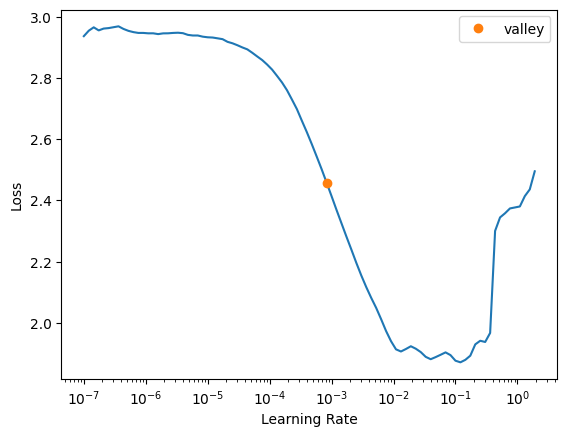

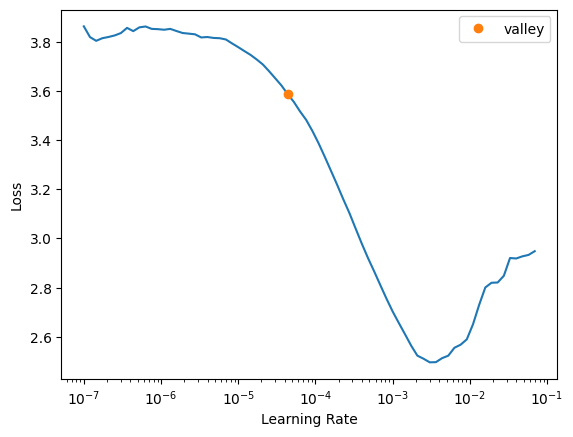

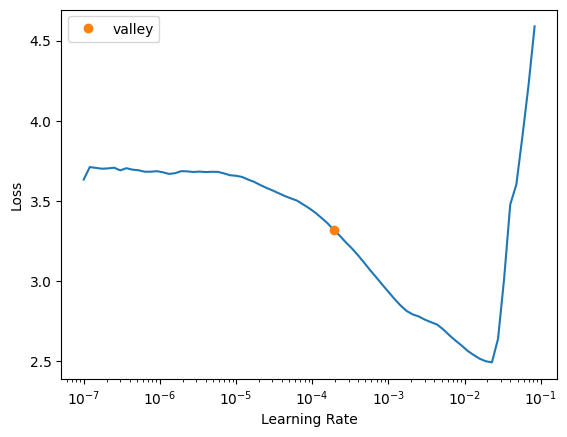

In [11]:
#Run the training and measure the time for each layer
for model, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][model] = end-start


<Figure size 1200x600 with 0 Axes>

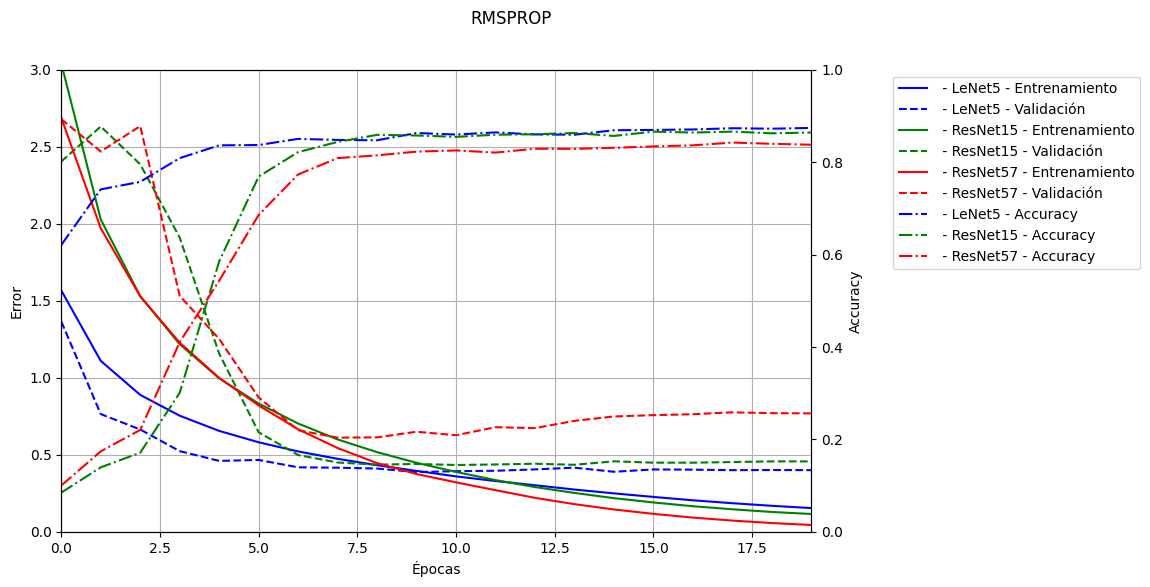

In [24]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), lim = 3, title='RMSPROP', names=models, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 2.2838172912597656.
Better model found at epoch 1 with valid_loss value: 1.4180208444595337.
Better model found at epoch 2 with valid_loss value: 0.806073784828186.
Better model found at epoch 3 with valid_loss value: 0.658475935459137.
Better model found at epoch 4 with valid_loss value: 0.5708692073822021.
Better model found at epoch 5 with valid_loss value: 0.5384281873703003.
Better model found at epoch 6 with valid_loss value: 0.5058069825172424.
Better model found at epoch 7 with valid_loss value: 0.48077094554901123.
Better model found at epoch 8 with valid_loss value: 0.4428172707557678.
Better model found at epoch 9 with valid_loss value: 0.42950910329818726.
Better model found at epoch 10 with valid_loss value: 0.41493070125579834.
Better model found at epoch 11 with valid_loss value: 0.4133928716182709.
Better model found at epoch 13 with valid_loss value: 0.4040146470069885.
Better model found at epoch 14 with valid_loss 

Better model found at epoch 0 with valid_loss value: 2.4236247539520264.
Better model found at epoch 2 with valid_loss value: 2.3760147094726562.
Better model found at epoch 3 with valid_loss value: 1.84247887134552.
Better model found at epoch 4 with valid_loss value: 1.086681842803955.
Better model found at epoch 5 with valid_loss value: 0.6844571232795715.
Better model found at epoch 6 with valid_loss value: 0.506784200668335.
Better model found at epoch 7 with valid_loss value: 0.4855773448944092.
Better model found at epoch 8 with valid_loss value: 0.4528302550315857.


Better model found at epoch 0 with valid_loss value: 2.652848482131958.
Better model found at epoch 2 with valid_loss value: 2.4945263862609863.
Better model found at epoch 3 with valid_loss value: 1.9872604608535767.
Better model found at epoch 4 with valid_loss value: 1.4449961185455322.
Better model found at epoch 5 with valid_loss value: 1.0835477113723755.
Better model found at epoch 6 with valid_loss value: 0.7361786961555481.
Better model found at epoch 7 with valid_loss value: 0.6297310590744019.
Better model found at epoch 8 with valid_loss value: 0.5991920828819275.
Better model found at epoch 9 with valid_loss value: 0.5947524309158325.


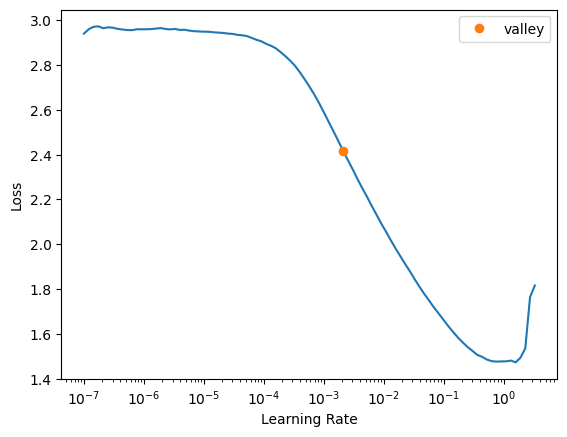

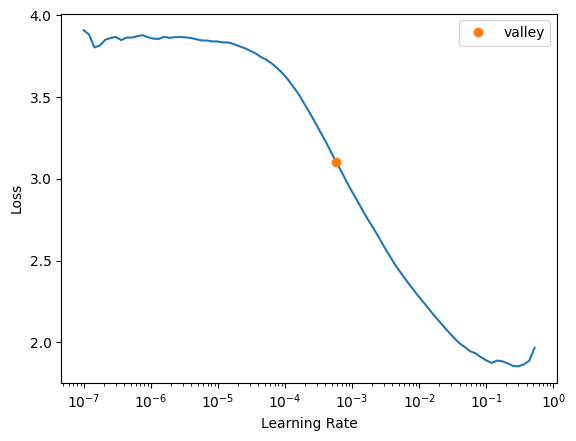

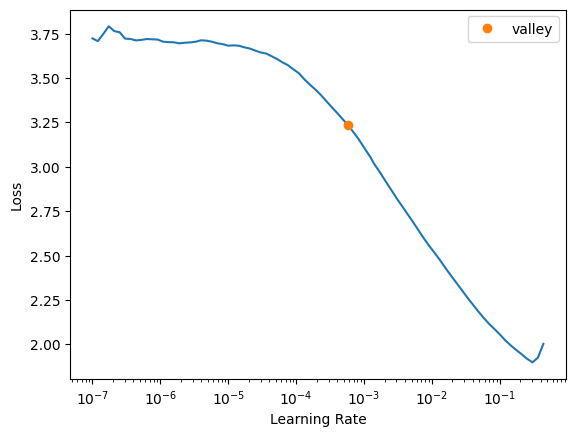

In [13]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][model] = end-start


<Figure size 1200x600 with 0 Axes>

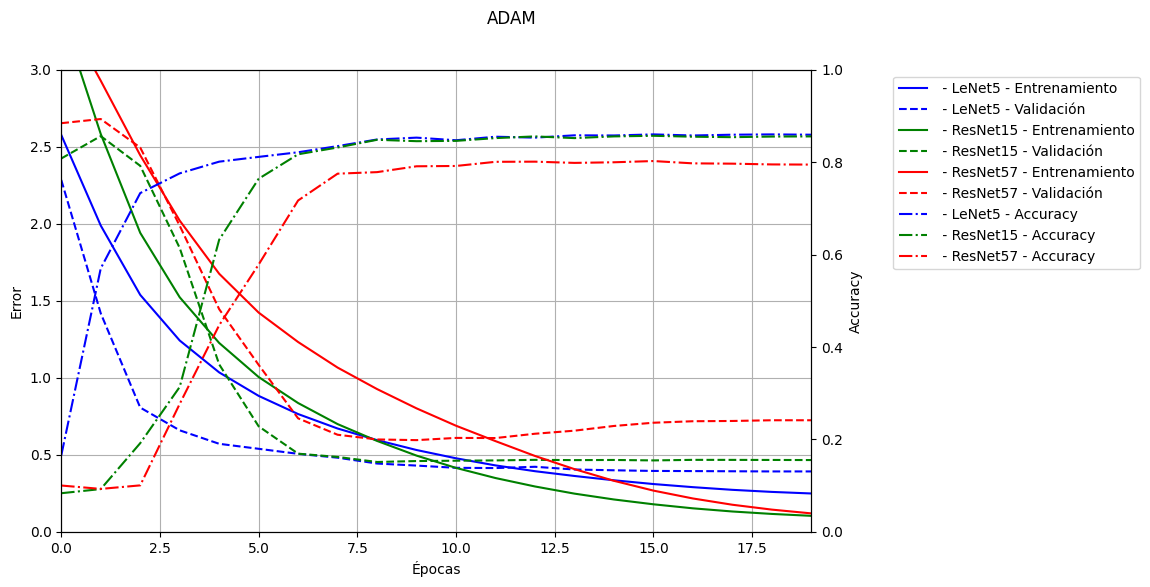

In [23]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), lim = 3, title='ADAM', names=models, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 2.280667543411255.
Better model found at epoch 1 with valid_loss value: 1.4080644845962524.
Better model found at epoch 2 with valid_loss value: 0.811129093170166.
Better model found at epoch 3 with valid_loss value: 0.661392092704773.
Better model found at epoch 4 with valid_loss value: 0.5706034898757935.
Better model found at epoch 5 with valid_loss value: 0.5310994386672974.
Better model found at epoch 6 with valid_loss value: 0.4891795516014099.
Better model found at epoch 7 with valid_loss value: 0.4720035791397095.
Better model found at epoch 8 with valid_loss value: 0.44250187277793884.
Better model found at epoch 10 with valid_loss value: 0.43573251366615295.
Better model found at epoch 11 with valid_loss value: 0.425566703081131.
Better model found at epoch 12 with valid_loss value: 0.4127857983112335.
Better model found at epoch 13 with valid_loss value: 0.4072127342224121.
Better model found at epoch 14 with valid_loss va

Better model found at epoch 0 with valid_loss value: 2.4275317192077637.
Better model found at epoch 3 with valid_loss value: 1.946537733078003.
Better model found at epoch 4 with valid_loss value: 1.2424098253250122.
Better model found at epoch 5 with valid_loss value: 0.7491499185562134.
Better model found at epoch 6 with valid_loss value: 0.5742599368095398.
Better model found at epoch 7 with valid_loss value: 0.46058735251426697.
Better model found at epoch 8 with valid_loss value: 0.4517689347267151.
Better model found at epoch 9 with valid_loss value: 0.4475262761116028.
Better model found at epoch 10 with valid_loss value: 0.4367116391658783.


Better model found at epoch 0 with valid_loss value: 2.6319491863250732.
Better model found at epoch 2 with valid_loss value: 2.4364287853240967.
Better model found at epoch 3 with valid_loss value: 1.8915836811065674.
Better model found at epoch 4 with valid_loss value: 1.40204656124115.
Better model found at epoch 5 with valid_loss value: 0.9826482534408569.
Better model found at epoch 6 with valid_loss value: 0.7111890316009521.
Better model found at epoch 7 with valid_loss value: 0.6167110204696655.


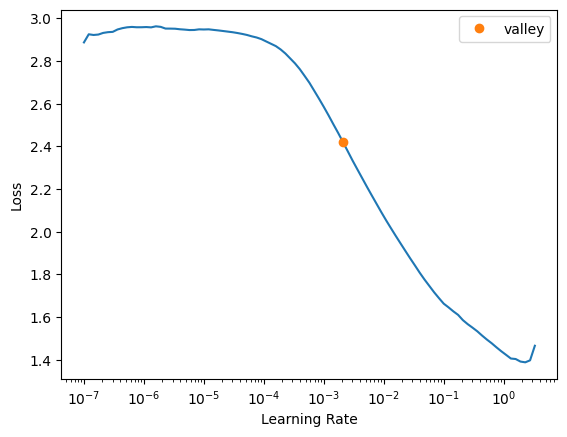

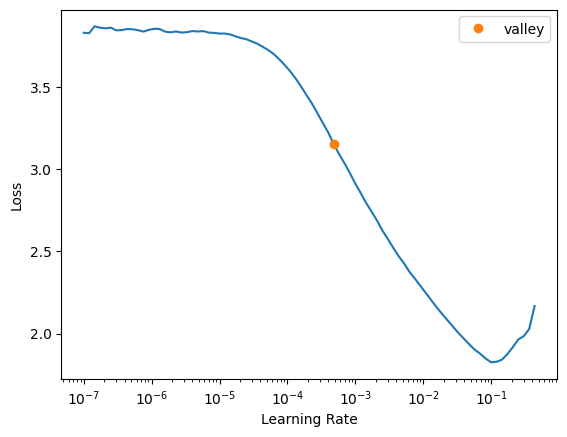

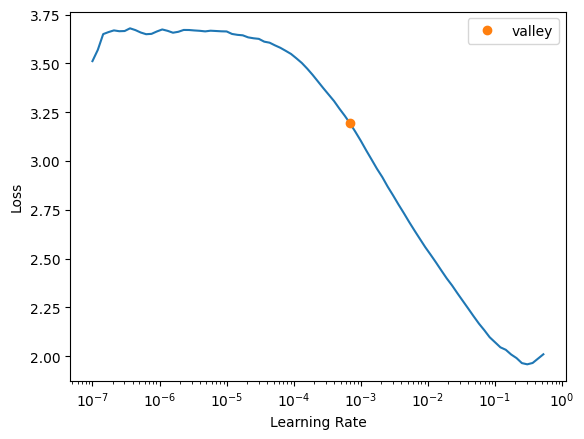

In [15]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][model] = end-start

<Figure size 1200x600 with 0 Axes>

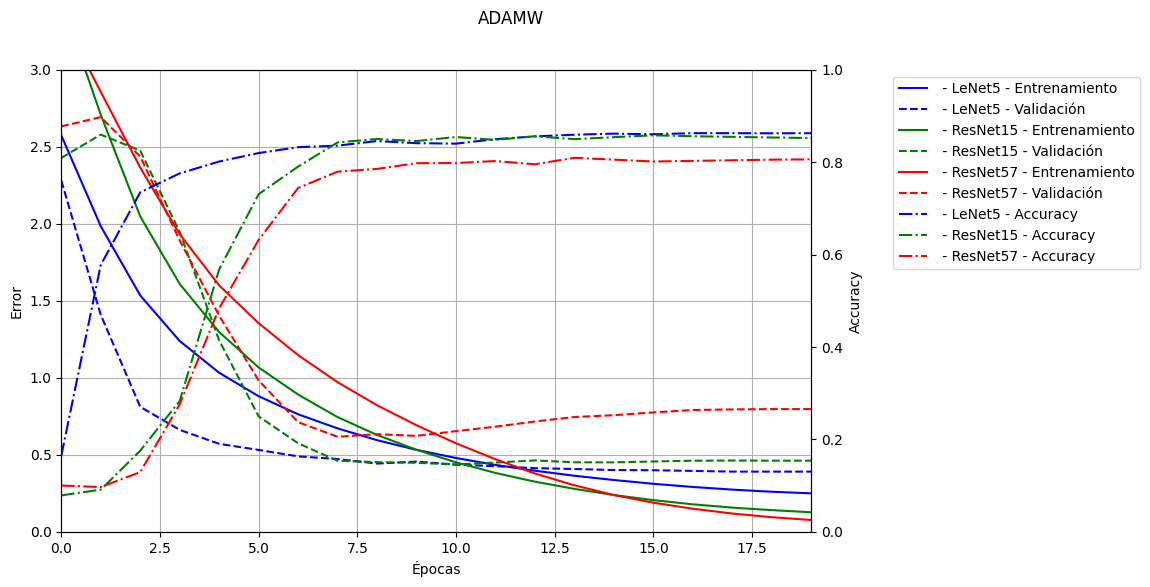

In [16]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), lim= 3, title='ADAMW', names=models, metric=metric)

# Test

In [18]:
start = time.perf_counter()
utilsTFG.LBFGS_SCIPY_full(utilsTFG.get_params_from_model(learners['ADAM']['ResNet57']), learners['ADAM']['ResNet57'].model, dls, max=10, task='clas')
end = time.perf_counter()
print(end-start)

41.58307365200017


In [12]:
start = time.perf_counter()
learners['ADAM']['LeNet5'].fit(1)
end = time.perf_counter()
print(end-start)

start = time.perf_counter()
learners['RMSProp']['ResNet57'].fit(10)
end = time.perf_counter()
print(end-start)




Better model found at epoch 0 with valid_loss value: 1.0566935539245605.
3.9729008419672027


Better model found at epoch 0 with valid_loss value: 2.6247053146362305.
4.541524817992467


In [17]:
ind = utilsTFG.get_params_from_model(learners['ADAM']['LeNet5'].model)
start = time.perf_counter()
utilsTFG.err_param(ind, learners['ADAM']['LeNet5'].model, dls )
end = time.perf_counter()
print(end-start)

ind = utilsTFG.get_params_from_model(learners['ADAM']['LeNet5'].model)
start = time.perf_counter()
utilsTFG.err_param(ind, learners['ADAM']['LeNet5'].model, dls )
utilsTFG.err_param_valid(ind, learners['ADAM']['LeNet5'].model, dls )
preds, targs = learners['ADAM']['LeNet5'].get_preds(dl=dls.valid)
targs = targs.long().squeeze()
# Calculate bal_accuracy
accuracy(preds, targs)
end = time.perf_counter()
print(end-start)


ind = utilsTFG.get_params_from_model(learners['ADAM']['ResNet57'].model)
start = time.perf_counter()
utilsTFG.err_param(ind, learners['ADAM']['ResNet57'].model, dls )
end = time.perf_counter()
print(end-start)

ind = utilsTFG.get_params_from_model(learners['RMSProp']['ResNet57'].model)
start = time.perf_counter()
utilsTFG.err_param(ind, learners['ADAM']['ResNet57'].model, dls )

end = time.perf_counter()
print(end-start)


ind = utilsTFG.get_params_from_model(learners['RMSProp']['ResNet57'].model)
start = time.perf_counter()
#utilsTFG.err_param(ind, learners['ADAM']['ResNet57'].model, dls )
utilsTFG.err_param_valid(ind, learners['ADAM']['ResNet57'].model, dls )
preds, targs = learners['ADAM']['ResNet57'].get_preds(dl=dls.valid)
targs = targs.long().squeeze()
# Calculate bal_accuracy
accuracy(preds, targs)
end = time.perf_counter()
print(end-start)

1.9387454580282792


5.350068016035948
2.38157989497995
2.2485036530415528


3.8335852680029348


### Save or Load models

In [17]:
#Save learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][model], 'recorder_values': learners[optim][model].recorder.values}, f)
        



In [18]:
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)
        

In [8]:
#Load learner with their losses and metrics
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][model], learners[optim][model].recorder.values = data['learner'], data['recorder_values']
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)

### Comparative per models

<Figure size 1200x600 with 0 Axes>

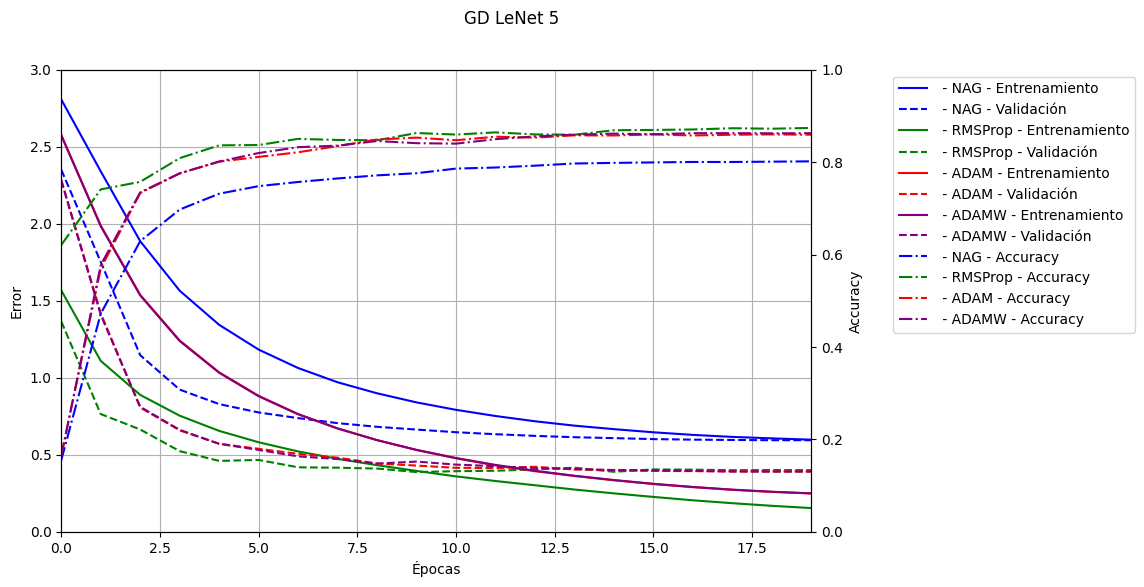

<Figure size 1200x600 with 0 Axes>

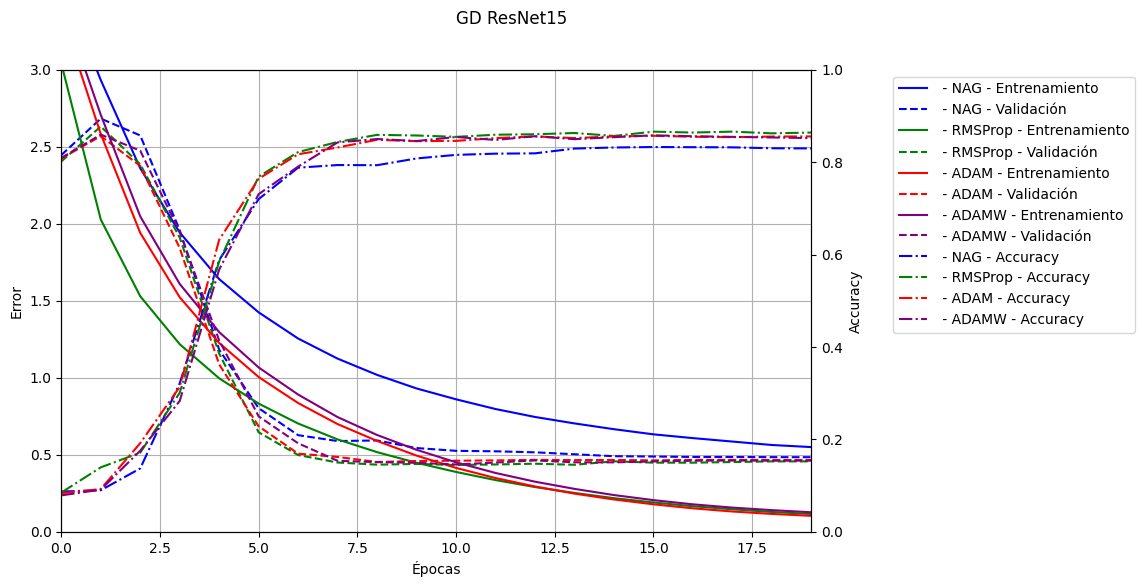

<Figure size 1200x600 with 0 Axes>

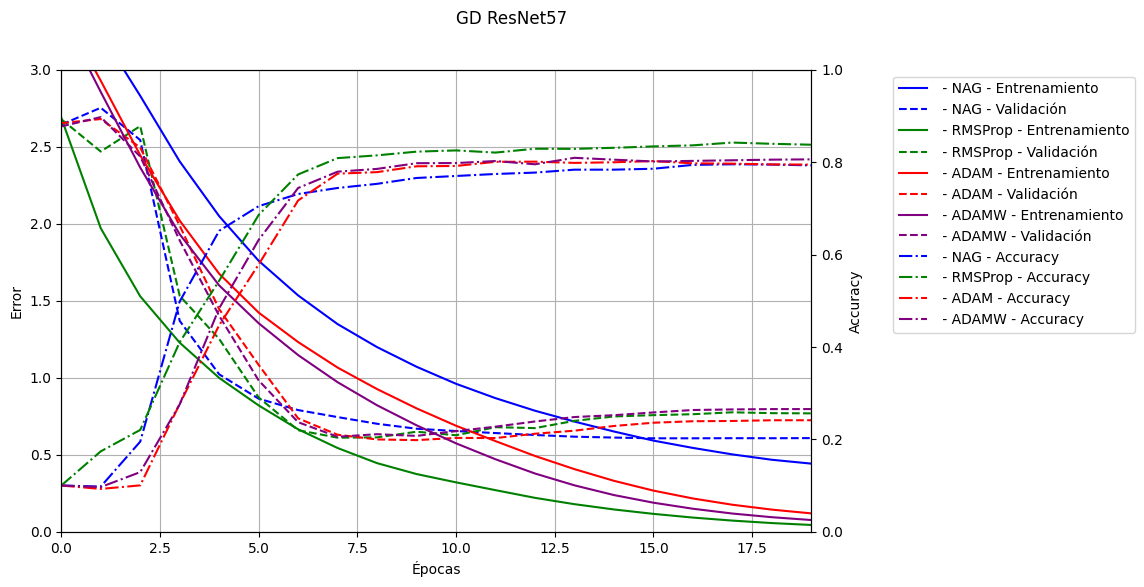

In [9]:
#Compare the three optimizers for each layer

learners_lenet =[learners['NAG']['LeNet5'], learners['RMSProp']['LeNet5'], learners['ADAM']['LeNet5'], learners['ADAMW']['LeNet5']]
learners_resnet = [learners['NAG']['ResNet15'], learners['RMSProp']['ResNet15'], learners['ADAM']['ResNet15'], learners['ADAMW']['ResNet15']]
learners_resnet57 = [learners['NAG']['ResNet57'], learners['RMSProp']['ResNet57'], learners['ADAM']['ResNet57'], learners['ADAMW']['ResNet57']]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_lenet, lim= 3, title='GD LeNet 5', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet, lim= 3, title='GD ResNet15', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet57, lim= 3, title='GD ResNet57', names=names, metric=metric)

### Generalization

In [20]:
models =['LeNet5', 'ResNet15', 'ResNet57'] #Sometimes it overrides the array
#Run the model in the test set
for optim in optims:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][model].model.eval()
    learners[optim][model].eval()
    preds, targs = learners[optim][model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][model].model, test_dl, mode = 'test')
    #loss = CrossEntropyLossFlat()(preds, targs)


    print(f"Optimizer: {optim}, Model: {model}, Loss: {loss}, Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: LeNet5, Loss: 0.6030401587486267, Accuracy: 0.7902


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: ResNet15, Loss: 0.5061915516853333, Accuracy: 0.8202


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: NAG, Model: ResNet57, Loss: 0.6372827887535095, Accuracy: 0.7732


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: LeNet5, Loss: 0.4119527339935303, Accuracy: 0.849


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: ResNet15, Loss: 0.45764800906181335, Accuracy: 0.8412


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: RMSProp, Model: ResNet57, Loss: 0.6462719440460205, Accuracy: 0.8034000000000001


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: LeNet5, Loss: 0.4101826250553131, Accuracy: 0.8573999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: ResNet15, Loss: 0.4728727340698242, Accuracy: 0.841


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAM, Model: ResNet57, Loss: 0.6227518916130066, Accuracy: 0.7779999999999999


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAMW, Model: LeNet5, Loss: 0.4122205674648285, Accuracy: 0.8538


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAMW, Model: ResNet15, Loss: 0.4648134410381317, Accuracy: 0.8428000000000001


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: ADAMW, Model: ResNet57, Loss: 0.6670252680778503, Accuracy: 0.7582


## Metaheuristics

In [9]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
optim=RMSProp
utilsTFG.set_seed()

#Initialise the population to have the same values for all the MH
for model,m in zip(models,mod):
  population[model] = []
  fitness[model] = []
  mh_learners[model] = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), opt_func=optim,  cbs=[SaveModelCallback()])
  mh_learners[model].to(device)
  mh_learners[model].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[model].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[model].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[model].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


In [25]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)

In [10]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [10]:
models=['LeNet5', 'ResNet15', 'ResNet57']
for alg in algs:
    results[alg] = {}
    for model in models:        
        file_path = f'/notebooks/saved_models/{alg}_dict_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            results[alg][model] = pickle.load(f)
        file_path = f'/notebooks/saved_models/{alg}_time_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            time_mh[alg][model] = pickle.load(f)

In [11]:
time_full_mh = {}
for alg in ['SHADE', 'SHADE-ILS']:
    time_full_mh[alg]= time_mh[alg]

### Genetic Algorithms

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [13]:
#Runing SHADE algorithm

results['SHADE'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'][model], f)
  file_path = f'/notebooks/saved_models/SHADE_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'][model], f)


In [12]:
#Runing SHADE algorithm

results['SHADE'] = {}
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'][model], f)
  file_path = f'/notebooks/saved_models/SHADE_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'][model], f)


In [14]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for model in models:
  fitness_valid['SHADE'][model] = []
  start = time.perf_counter()
  for ind in results['SHADE'][model][5]:
    fitness_valid['SHADE'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))
  end = time.perf_counter()
  time_full_mh['SHADE'][model]+= end-start

In [16]:
#compare train and valid and select the best generalizing model.
for model in models:
  print(f"Training error of SHADE for {model} model: {results['SHADE'][model][6]}")
  print(f"Validation error of SHADE for {model} model: {fitness_valid['SHADE'][model]}")
  dif = np.array(fitness_valid['SHADE'][model]) - np.array(results['SHADE'][model][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][model])
  best['SHADE'][model] = results['SHADE'][model][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")
    

Training error of SHADE for LeNet5 model: [2.4844369888305664, 2.435077667236328, 2.435077667236328, 2.435077667236328, 2.3328421115875244, 2.2463345527648926, 2.2463345527648926, 2.2463345527648926, 2.246086359024048, 2.246086359024048, 2.2197322845458984, 2.1903300285339355, 2.1896157264709473, 2.1896157264709473, 2.1896157264709473, 2.1556365489959717, 2.1529934406280518, 2.1529934406280518, 2.149435520172119, 2.149435520172119, 2.1093080043792725, 2.1093080043792725, 2.1093080043792725, 2.0423340797424316, 2.0423340797424316, 2.0423340797424316, 2.0423340797424316, 2.0044937133789062, 1.995662808418274, 1.9942325353622437, 1.9881104230880737, 1.9552085399627686, 1.9518507719039917, 1.9342224597930908, 1.9148473739624023, 1.9047287702560425, 1.8706916570663452, 1.843605875968933, 1.8040226697921753, 1.7969725131988525, 1.7889295816421509, 1.7620561122894287, 1.7620561122894287, 1.7349082231521606, 1.7304186820983887, 1.7261629104614258, 1.7083380222320557, 1.7080168724060059, 1.7064

In [13]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for model in models:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][model])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][model] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][model] = [np.mean(fitness_valid['SHADE'][model][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][model]), 5)]

### SHADE-ILS

In [13]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'][model], f)


deque([1, 1, 0.8377264194254317], maxlen=3)
233
deque([1, 0.8377264194254317, 0.2008629074715581], maxlen=3)
445
deque([0.8377264194254317, 0.2008629074715581, 0.015772029678470897], maxlen=3)
657
deque([0.2008629074715581, 0.015772029678470897, 0.12409114413818162], maxlen=3)
870
deque([0.015772029678470897, 0.12409114413818162, -0.007731263250838842], maxlen=3)
1088
deque([0.12409114413818162, -0.007731263250838842, 0.014116863893039696], maxlen=3)
1297
deque([-0.007731263250838842, 0.014116863893039696, -0.012456308150498252], maxlen=3)
Reiniciado
1516
deque([1, 1, 0.7794482653949325], maxlen=3)
1727
deque([1, 0.7794482653949325, 0.21225625106316914], maxlen=3)
1939
deque([0.7794482653949325, 0.21225625106316914, 0.17489568061989158], maxlen=3)
2152
deque([0.21225625106316914, 0.17489568061989158, 0.033088997480907954], maxlen=3)
2364
deque([0.17489568061989158, 0.033088997480907954, -0.01682971945936682], maxlen=3)
2573
deque([0.033088997480907954, -0.01682971945936682, -0.00442086

In [11]:
results['SHADE-ILS'] = {}
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'][model], f)

deque([1, 1, 0.20995182884907623], maxlen=3)
242
deque([1, 0.20995182884907623, 0.03132467574170656], maxlen=3)
459
deque([0.20995182884907623, 0.03132467574170656, 0.011168079677415493], maxlen=3)
691
deque([0.03132467574170656, 0.011168079677415493, 0.03873201367750657], maxlen=3)
Reiniciado
922
deque([1, 1, 0.7444646574370766], maxlen=3)
1133
deque([1, 0.7444646574370766, 0.500204127394949], maxlen=3)
1345
deque([0.7444646574370766, 0.500204127394949, 0.4476024370797367], maxlen=3)
1557
deque([0.500204127394949, 0.4476024370797367, 0.35624008873916435], maxlen=3)
1770
deque([0.4476024370797367, 0.35624008873916435, 0.3363666578173501], maxlen=3)
1983
deque([0.35624008873916435, 0.3363666578173501, 0.07818178083548079], maxlen=3)
2196
deque([0.3363666578173501, 0.07818178083548079, 0.03611997406875519], maxlen=3)
2412
deque([0.07818178083548079, 0.03611997406875519, 0.001883433697125021], maxlen=3)
2635
deque([0.03611997406875519, 0.001883433697125021, 0.02980274719664827], maxlen=3)

In [14]:
fitness_valid['SHADE-ILS'] = {}
for model in models:
  fitness_valid['SHADE-ILS'][model] = []
  start = time.perf_counter()
  for ind in results['SHADE-ILS'][model][3]:
    fitness_valid['SHADE-ILS'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))
  end = time.perf_counter()
  time_full_mh['SHADE-ILS'][model] += end-start

In [15]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS for {model} model: {results['SHADE-ILS'][model][2]}")
  print(f"Validation error of SHADE-ILS for {model} model: {fitness_valid['SHADE-ILS'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS'][model]) - np.array(results['SHADE-ILS'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][model])
  best['SHADE-ILS'][model] = results['SHADE-ILS'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for LeNet5 model: [2.4844369888305664, 0.4031584858894348, 0.3221789002418518, 0.3170974850654602, 0.2777484953403473, 0.2777484953403473, 0.2759445905685425, 0.2759445905685425, 0.2759445905685425, 0.2759445905685425, 0.26076966524124146, 0.2521410584449768, 0.2521410584449768, 0.2521410584449768, 0.2521410584449768, 0.2521410584449768, 0.2521410584449768, 0.2521410584449768, 0.24751898646354675, 0.24751898646354675, 0.24432216584682465]
Validation error of SHADE-ILS for LeNet5 model: [2.295497417449951, 1.7919409275054932, 1.8990983963012695, 1.8867881298065186, 1.8844159841537476, 1.8844159841537476, 1.8794615268707275, 1.8794615268707275, 1.8794615268707275, 1.8794615268707275, 2.068925380706787, 1.9734854698181152, 1.9734854698181152, 1.9734854698181152, 1.9734854698181152, 1.9734854698181152, 1.9734854698181152, 1.9734854698181152, 5.363426208496094, 5.363426208496094, 4.927370071411133]
Difference: [-0.18893957  1.38878244  1.5769195   1.56969064  1.6

### SHADE-GD

In [ ]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'][model], f)


deque([1, 1, 0.09583758297599229], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0006886720657349.
deque([1, 0.09583758297599229, 0.461214511861309], maxlen=3)
deque([0.09583758297599229, 0.461214511861309, 0.11529815460348407], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8040422201156616.
deque([0.461214511861309, 0.11529815460348407, 0.1965912702896933], maxlen=3)
deque([0.11529815460348407, 0.1965912702896933, 0.07445568776346224], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6674696803092957.
deque([0.1965912702896933, 0.07445568776346224, 0.11398037308623817], maxlen=3)
deque([0.07445568776346224, 0.11398037308623817, 0.10878695132143844], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6033666133880615.
deque([0.11398037308623817, 0.10878695132143844, 0.02929873685697478], maxlen=3)
deque([0.10878695132143844, 0.02929873685697478, 0.05909352168772778], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.586944043636322.
deque([0.02929873685697478, 0.05909352168772778, 0.005087501771107054], maxlen=3)
deque([0.05909352168772778, 0.005087501771107054, 0.02280278770756969], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5730422139167786.
deque([0.005087501771107054, 0.02280278770756969, 0.006313851043423754], maxlen=3)
Reiniciado
deque([1, 1, 0.09130502606465092], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9016374349594116.
deque([1, 0.09130502606465092, 0.5914073822884537], maxlen=3)
deque([0.09130502606465092, 0.5914073822884537, 0.21066160013880275], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.690542459487915.
deque([0.5914073822884537, 0.21066160013880275, 0.016152698145693235], maxlen=3)
deque([0.21066160013880275, 0.016152698145693235, 0.08642230850042946], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6181820631027222.
deque([0.016152698145693235, 0.08642230850042946, 0.044385923226615547], maxlen=3)
deque([0.08642230850042946, 0.044385923226615547, 0.05333468850391776], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5859940648078918.
deque([0.044385923226615547, 0.05333468850391776, 0.012647009242851412], maxlen=3)
deque([0.05333468850391776, 0.012647009242851412, 0.055702401712080005], maxlen=3)
deque([1, 1, 0.18582645303054848], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1032224893569946.
deque([1, 0.18582645303054848, 0.5663206292887626], maxlen=3)
deque([0.18582645303054848, 0.5663206292887626, 0.10359651832240213], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7434378266334534.
deque([0.5663206292887626, 0.10359651832240213, 0.2007551379163333], maxlen=3)
deque([0.10359651832240213, 0.2007551379163333, 0.00031566879036742533], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.1518421173095703.
deque([0.2007551379163333, 0.00031566879036742533, 0.010950361422661876], maxlen=3)
deque([0.00031566879036742533, 0.010950361422661876, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.2227619886398315.
deque([1, 1, 0.7526603229513723], maxlen=3)
deque([1, 0.7526603229513723, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.3004674911499023.
deque([0.7526603229513723, 0.0, 0.07997329323465467], maxlen=3)
deque([0.0, 0.07997329323465467, 0.09524559980837204], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8194558024406433.
deque([0.07997329323465467, 0.09524559980837204, 0.11930646212687014], maxlen=3)
deque([0.09524559980837204, 0.11930646212687014, 0.0998739945587313], maxlen=3)


deque([1, 1, 0.18602960514539715], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.569032907485962.
deque([1, 0.18602960514539715, 0.46071393693326795], maxlen=3)
deque([0.18602960514539715, 0.46071393693326795, 0.06504974243805614], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9689772129058838.
deque([0.46071393693326795, 0.06504974243805614, 0.15895242155756567], maxlen=3)
deque([0.06504974243805614, 0.15895242155756567, 0.07381320503290366], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8699648976325989.
deque([0.15895242155756567, 0.07381320503290366, 0.06789332010152664], maxlen=3)
deque([0.07381320503290366, 0.06789332010152664, 0.12793001371039786], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8230523467063904.
deque([0.06789332010152664, 0.12793001371039786, 0.011608817152689362], maxlen=3)
deque([0.12793001371039786, 0.011608817152689362, 0.130678108794874], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7634810209274292.
deque([0.011608817152689362, 0.130678108794874, 0.008280616218986746], maxlen=3)
deque([0.130678108794874, 0.008280616218986746, 0.1018782100834212], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7426286339759827.
deque([0.008280616218986746, 0.1018782100834212, -0.0015017076698177843], maxlen=3)
deque([0.1018782100834212, -0.0015017076698177843, 0.06559305905461038], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.735392153263092.
deque([-0.0015017076698177843, 0.06559305905461038, 0.009531918019484515], maxlen=3)
deque([0.06559305905461038, 0.009531918019484515, 0.03180858366030525], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7343253493309021.
deque([0.009531918019484515, 0.03180858366030525, 0.00067045968639031], maxlen=3)
Reiniciado
deque([1, 1, 0.4315488707545503], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.6963768005371094.
deque([1, 0.4315488707545503, 0.32181168731170556], maxlen=3)
deque([0.4315488707545503, 0.32181168731170556, 0.27271397269746667], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.0650444030761719.
deque([0.32181168731170556, 0.27271397269746667, 0.08197222425730044], maxlen=3)
deque([0.27271397269746667, 0.08197222425730044, 0.07322108725635093], maxlen=3)


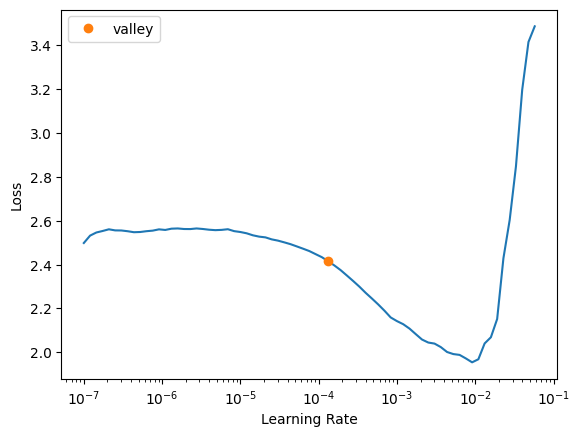

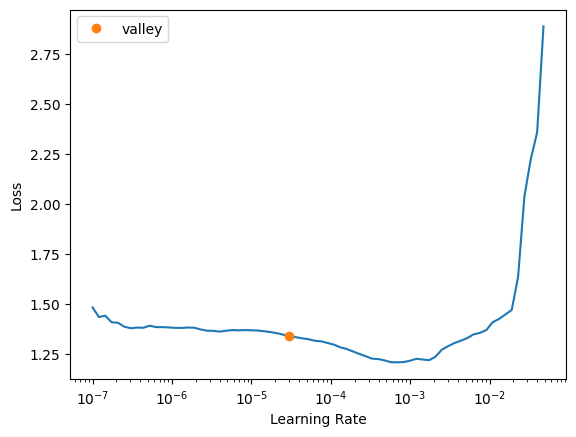

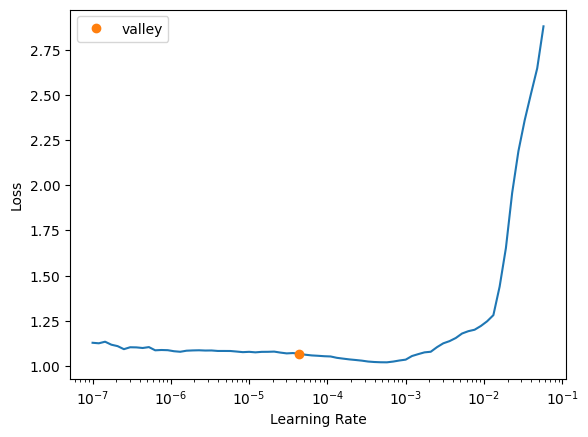

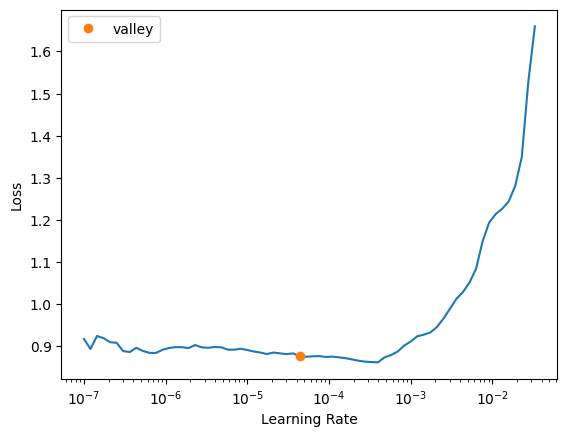

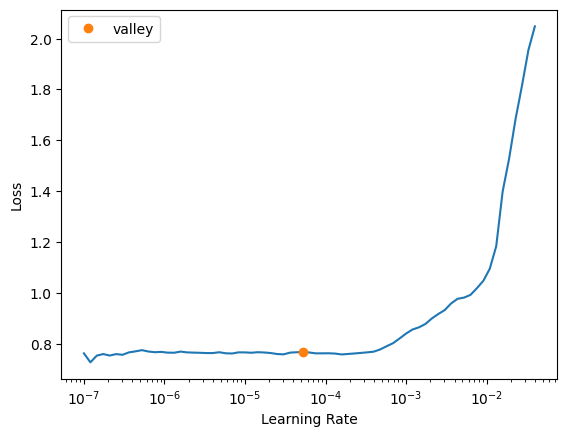

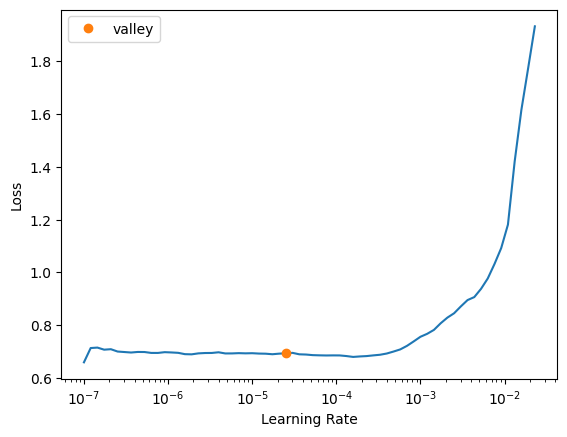

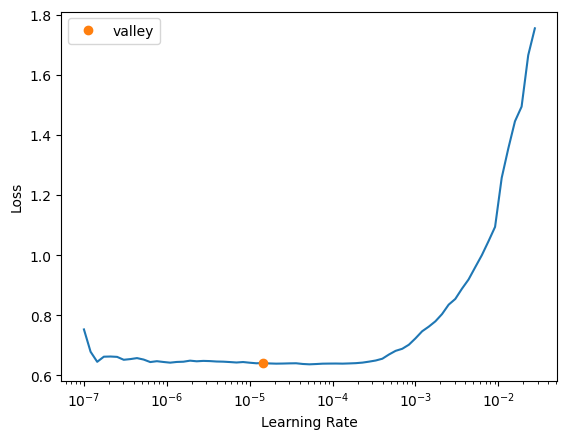

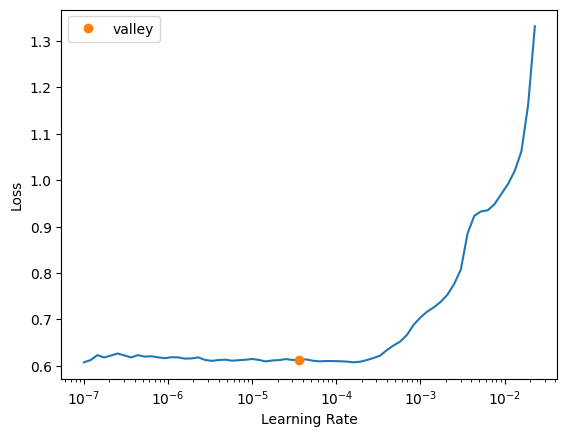

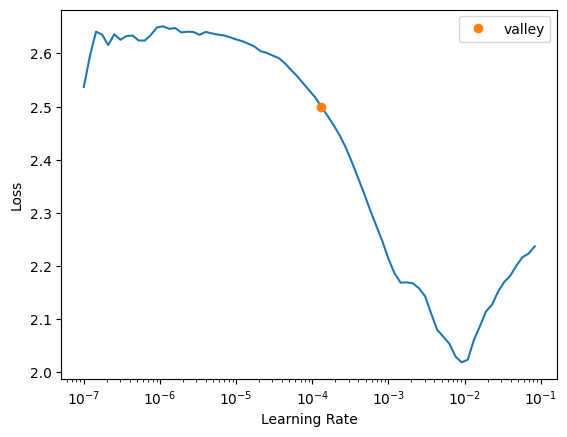

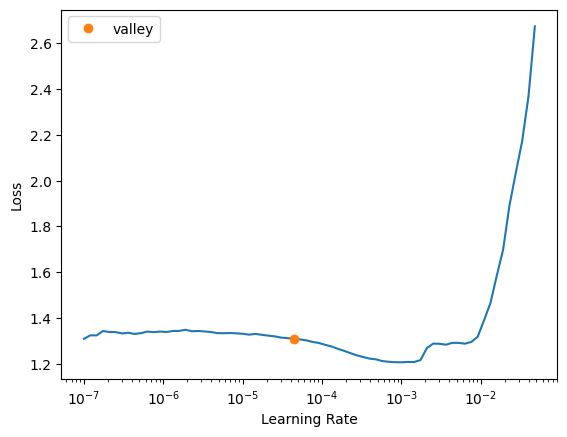

In [12]:
results['SHADE-GD'] = {}
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'][model], f)


In [16]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for model in models:
  fitness_valid['SHADE-GD'][model] = []
  for ind in results['SHADE-GD'][model][3]:
    fitness_valid['SHADE-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [17]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-GD for {model} model: {results['SHADE-GD'][model][2]}")
  print(f"Validation error of SHADE-GD for {model} model: {fitness_valid['SHADE-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-GD'][model]) - np.array(results['SHADE-GD'][model][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][model])
  best['SHADE-GD'][model] = results['SHADE-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for LeNet5 model: [2.4844369888305664, 2.2463345527648926, 1.2102924585342407, 1.070747971534729, 0.8602482676506042, 0.7961978912353516, 0.7054469585418701, 0.6287035346031189, 0.6102833151817322, 0.5742195248603821, 0.5712981820106506, 0.5582709908485413, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459, 0.554746150970459]
Validation error of SHADE-GD for LeNet5 model: [2.295497417449951, 2.3048713207244873, 2.2500665187835693, 2.2130651473999023, 2.168891429901123, 2.1813299655914307, 2.1335082054138184, 2.133903980255127, 2.1425082683563232, 2.1414427757263184, 2.1443209648132324, 2.14469051361084, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166, 2.148043155670166]
Difference: [-0.18893957  0.05853677  1.03977406  1.

### SHADE-ILS-GD

deque([1, 1, 0.8407762657665421], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.42922261357307434.
deque([1, 0.8407762657665421, 0.029147308243405456], maxlen=3)
deque([0.8407762657665421, 0.029147308243405456, 0.008793306545859194], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.41977784037590027.
deque([0.029147308243405456, 0.008793306545859194, 0.0036199717786408276], maxlen=3)
Reiniciado
deque([1, 1, 0.7508630774871231], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.455918550491333.
deque([1, 0.7508630774871231, 0.22725750147491502], maxlen=3)
deque([0.7508630774871231, 0.22725750147491502, 0.004134932210291464], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4189921021461487.
deque([0.22725750147491502, 0.004134932210291464, 0.027776555942755073], maxlen=3)
deque([0.004134932210291464, 0.027776555942755073, 0.1983887926171375], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.3904632031917572.
deque([0.027776555942755073, 0.1983887926171375, 0.11331153033837285], maxlen=3)
deque([0.1983887926171375, 0.11331153033837285, 0.004557571388712961], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.3921472132205963.
deque([0.11331153033837285, 0.004557571388712961, 0.0003656116194822969], maxlen=3)
deque([0.004557571388712961, 0.0003656116194822969, 0.010428306517116868], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.096923828125.
deque([1, 1, 0.6559292062576206], maxlen=3)
deque([1, 0.6559292062576206, 0.24203615809814175], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.0589048862457275.
deque([0.6559292062576206, 0.24203615809814175, 0.13419462425813725], maxlen=3)
deque([0.24203615809814175, 0.13419462425813725, 0.04171870485777897], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.40771540999412537.
deque([0.13419462425813725, 0.04171870485777897, -0.009534418106481006], maxlen=3)
deque([0.04171870485777897, -0.009534418106481006, 0.1492716980675574], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.41367509961128235.
deque([-0.009534418106481006, 0.1492716980675574, -0.010430913116992452], maxlen=3)
deque([1, 1, 0.9016595740676386], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4693453907966614.
deque([1, 0.9016595740676386, 0.27650226946268025], maxlen=3)
deque([0.9016595740676386, 0.27650226946268025, 0.04146466815086272], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.3857102394104004.
deque([0.27650226946268025, 0.04146466815086272, 0.033792337982886285], maxlen=3)
deque([0.04146466815086272, 0.033792337982886285, 0.017630197788799373], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 1.8781418800354004.
deque([1, 1, 0.907719433003029], maxlen=3)
deque([1, 0.907719433003029, 0.3929353460305527], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.6824063062667847.
deque([0.907719433003029, 0.3929353460305527, 0.07611585753557781], maxlen=3)
deque([0.3929353460305527, 0.07611585753557781, 0.26588563406091476], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.5714607238769531.
deque([0.07611585753557781, 0.26588563406091476, 0.07935122232795924], maxlen=3)
deque([0.26588563406091476, 0.07935122232795924, 0.061506941478017184], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.3785138726234436.
deque([0.07935122232795924, 0.061506941478017184, -0.01588891918226146], maxlen=3)
deque([0.061506941478017184, -0.01588891918226146, 0.010435709395314696], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.38051891326904297.
deque([-0.01588891918226146, 0.010435709395314696, 0.1653092028283275], maxlen=3)
deque([0.010435709395314696, 0.1653092028283275, 0.14368393540824692], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.38088908791542053.
deque([0.1653092028283275, 0.14368393540824692, 0.03645184943432523], maxlen=3)
deque([0.14368393540824692, 0.03645184943432523, 0.09424059954284364], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.384978324174881.
deque([0.03645184943432523, 0.09424059954284364, 0.0001727493068425942], maxlen=3)
deque([0.09424059954284364, 0.0001727493068425942, 0.03595541349125136], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.5000629425048828.
deque([0.0001727493068425942, 0.03595541349125136, 0.005319538651582351], maxlen=3)
Reiniciado


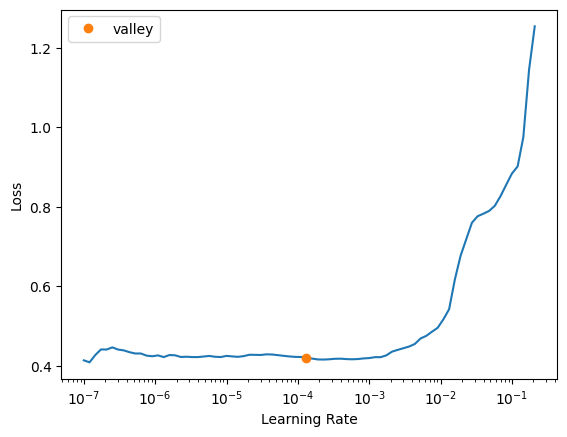

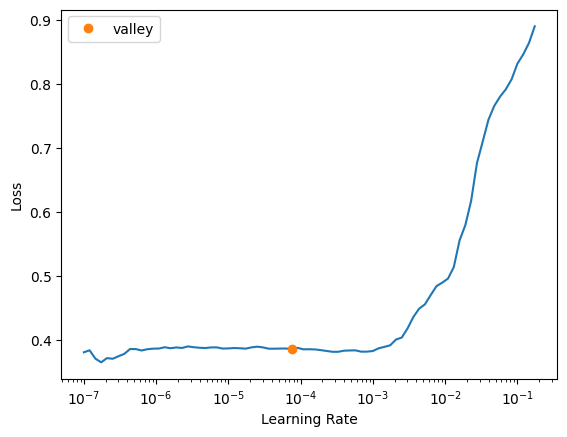

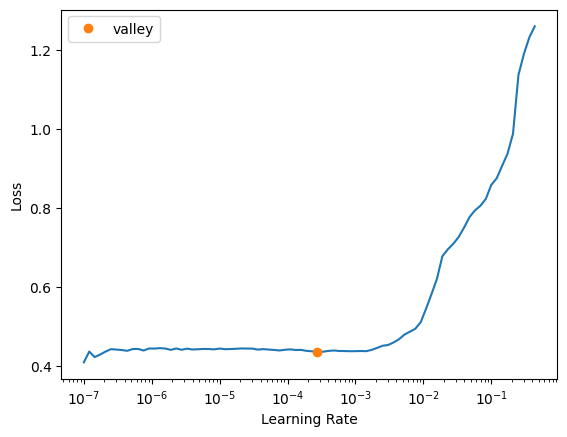

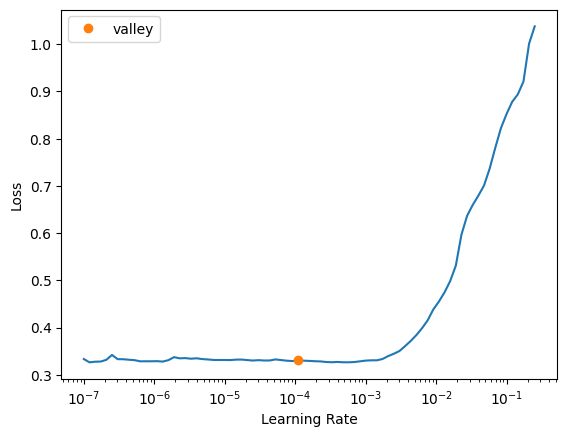

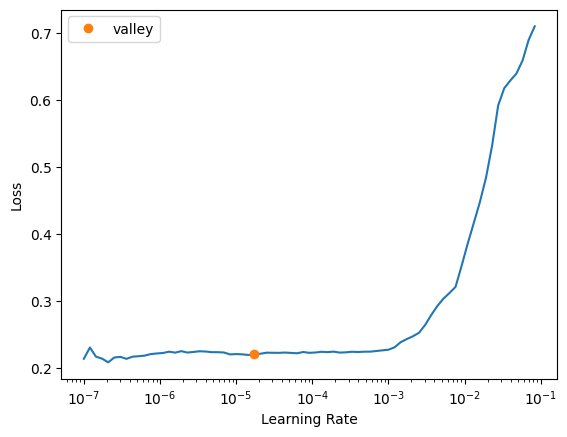

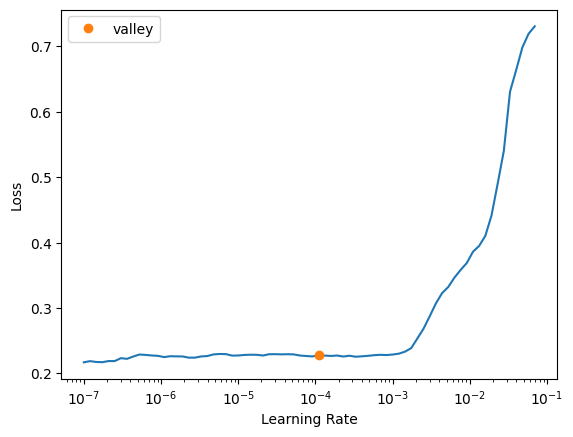

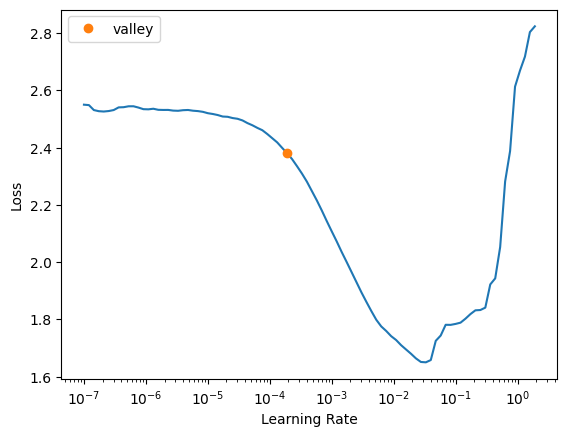

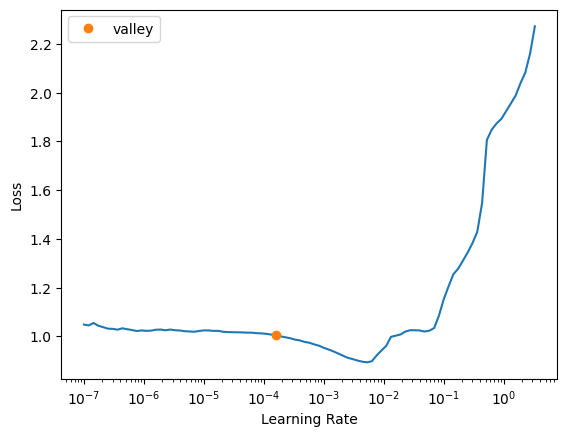

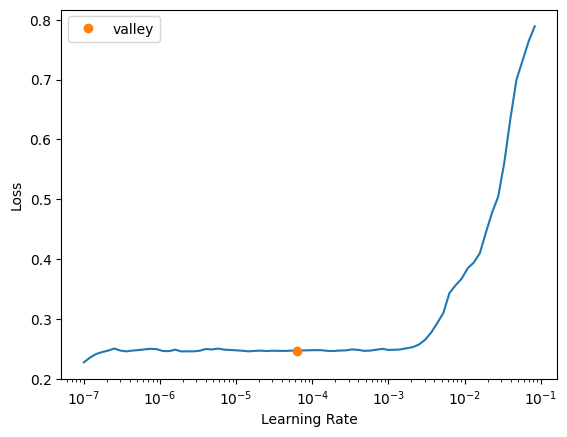

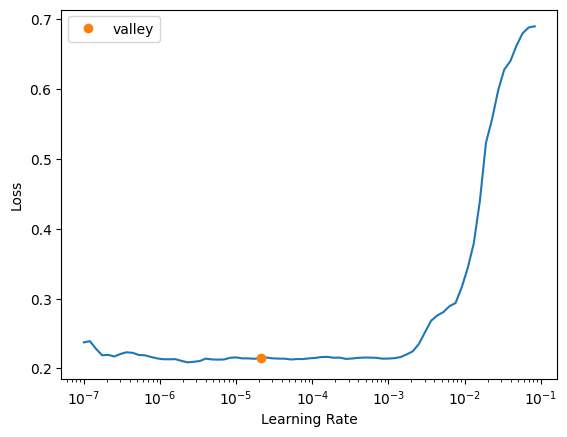

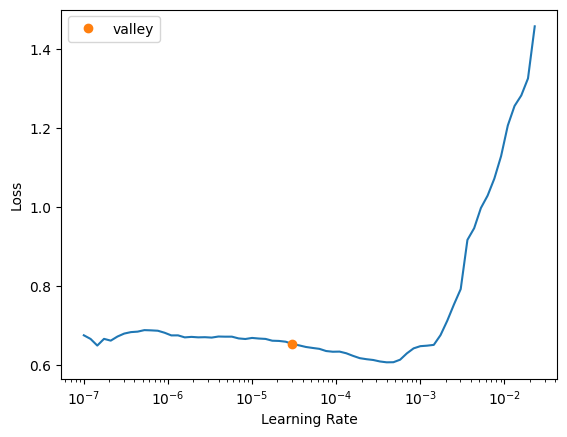

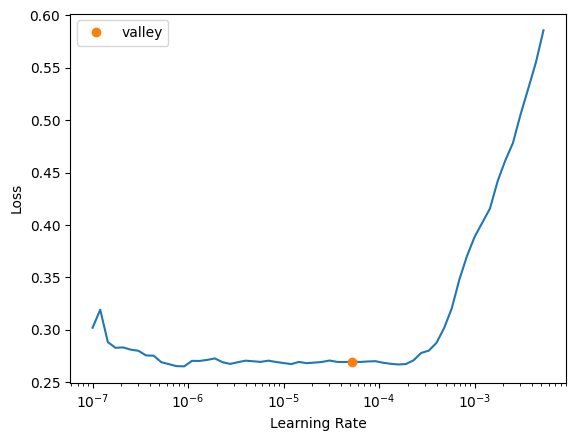

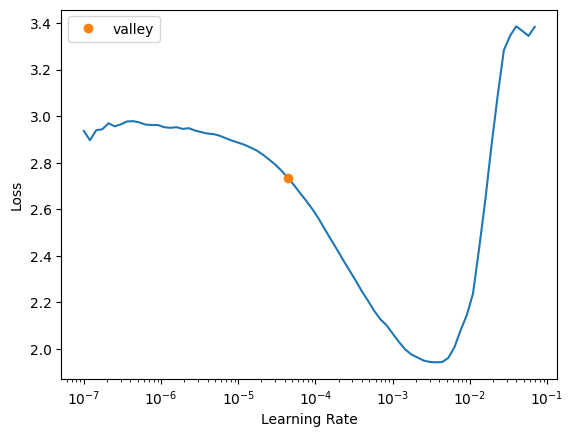

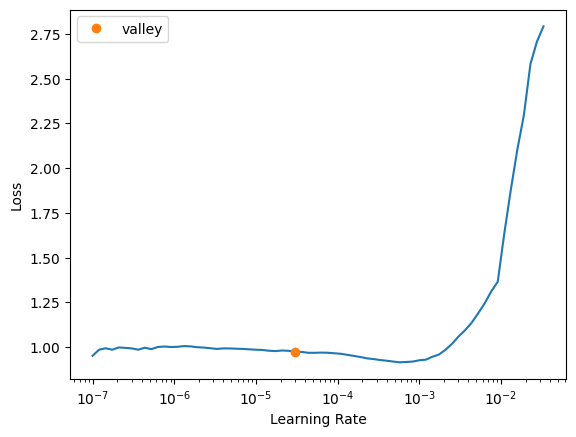

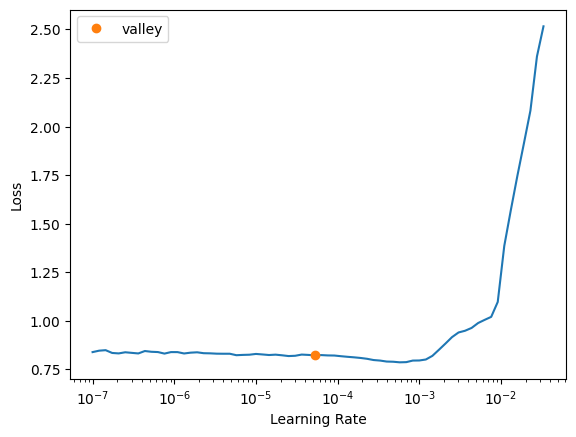

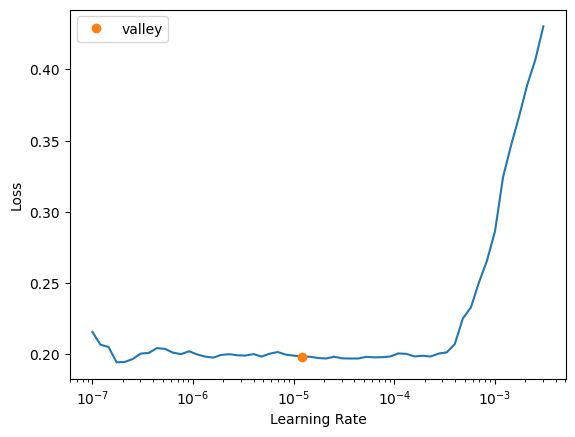

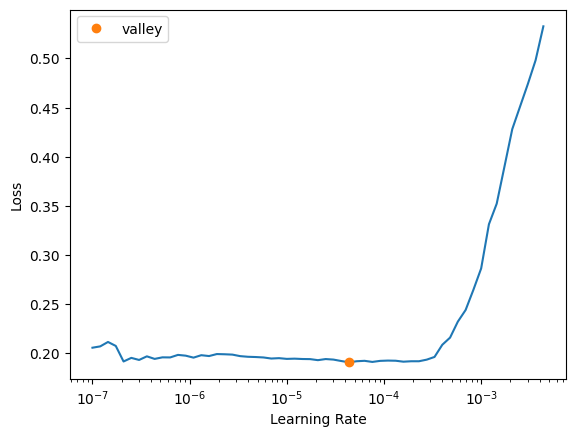

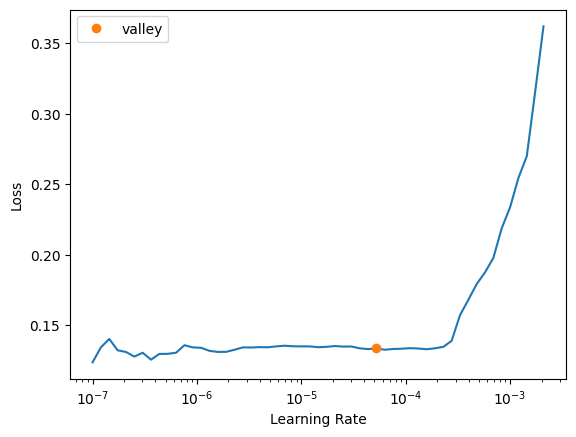

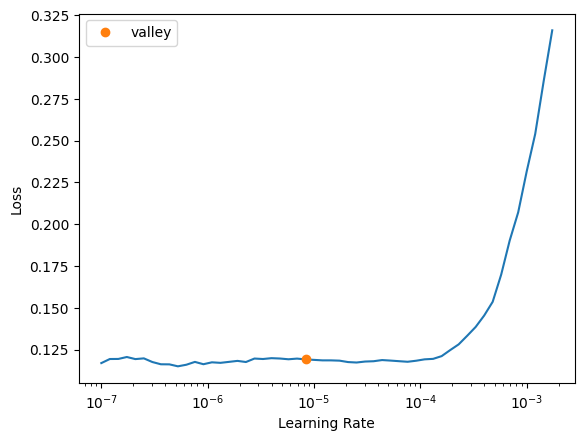

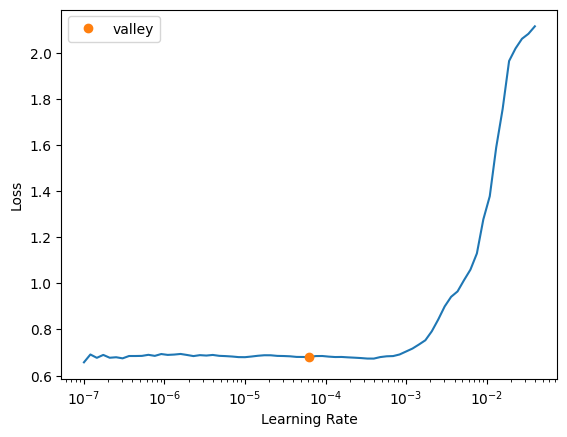

In [11]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'][model], f)


deque([1, 1, 0.21585483144889203], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.694758415222168.
deque([1, 0.21585483144889203, 0.3721118645697639], maxlen=3)
deque([0.21585483144889203, 0.3721118645697639, 0.2748804861850618], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.9406716227531433.
deque([0.3721118645697639, 0.2748804861850618, 0.08076529134851738], maxlen=3)
deque([0.2748804861850618, 0.08076529134851738, 0.06502304068301774], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8469661474227905.
deque([0.08076529134851738, 0.06502304068301774, 0.05757528015104604], maxlen=3)
deque([0.06502304068301774, 0.05757528015104604, 0.09274093564322837], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8076708912849426.
deque([0.05757528015104604, 0.09274093564322837, 0.019933163954467148], maxlen=3)
deque([0.09274093564322837, 0.019933163954467148, 0.11126318934784221], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7766405344009399.
deque([0.019933163954467148, 0.11126318934784221, 0.012452200916508878], maxlen=3)
deque([0.11126318934784221, 0.012452200916508878, 0.08849206011533835], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7296279072761536.
deque([0.012452200916508878, 0.08849206011533835, 0.004697963987215043], maxlen=3)
deque([0.08849206011533835, 0.004697963987215043, 0.11506140233727469], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7193046808242798.
deque([0.004697963987215043, 0.11506140233727469, 0.020347880929851563], maxlen=3)
deque([0.11506140233727469, 0.020347880929851563, 0.10827724792834302], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.7065051794052124.
deque([0.020347880929851563, 0.10827724792834302, 0.003083547644829453], maxlen=3)
deque([0.10827724792834302, 0.003083547644829453, 0.02476600879891328], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6986797451972961.
deque([0.003083547644829453, 0.02476600879891328, 0.006946064017272594], maxlen=3)
Reiniciado
deque([1, 1, 0.583130916891406], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.3994219303131104.
deque([1, 0.583130916891406, 0.37764709898855925], maxlen=3)


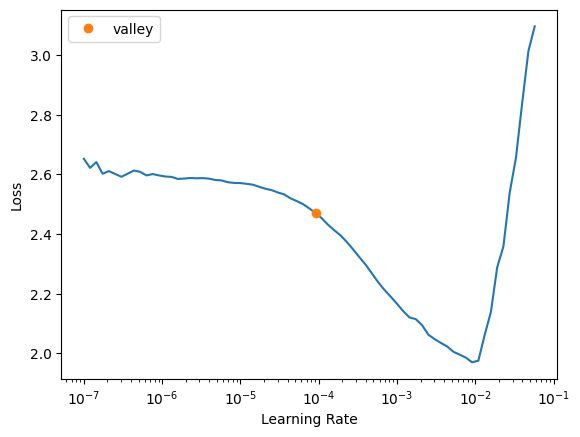

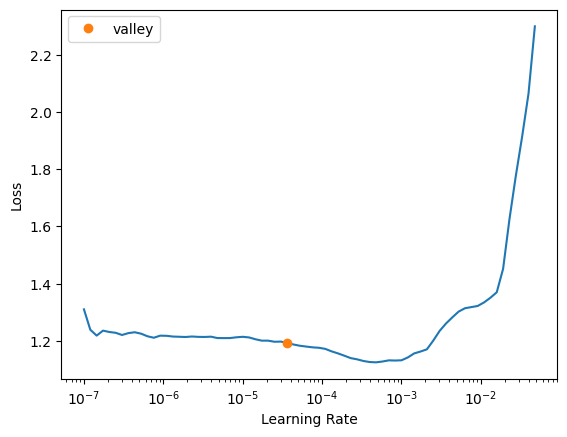

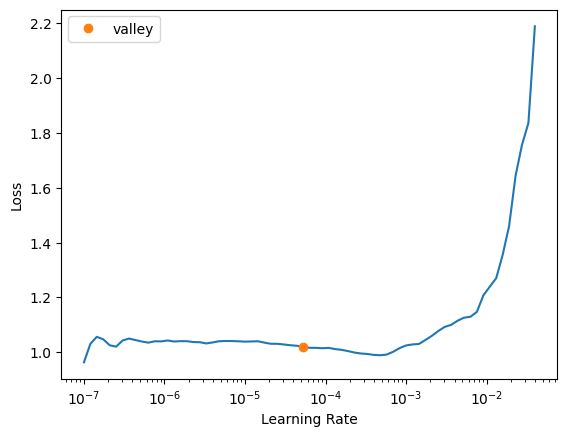

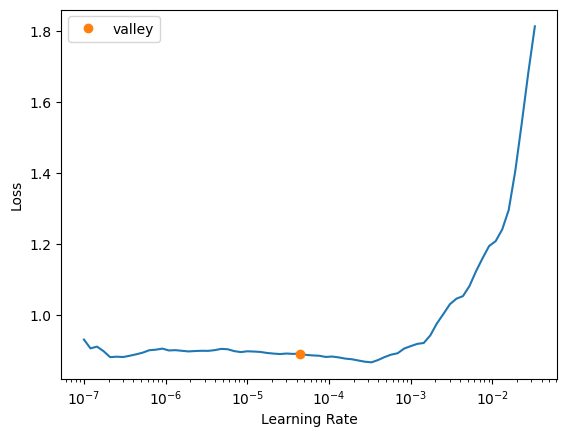

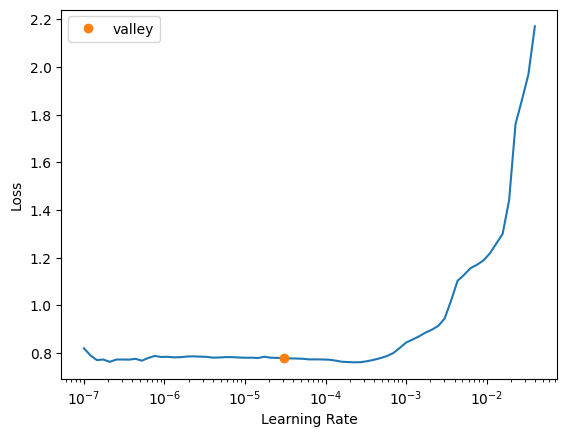

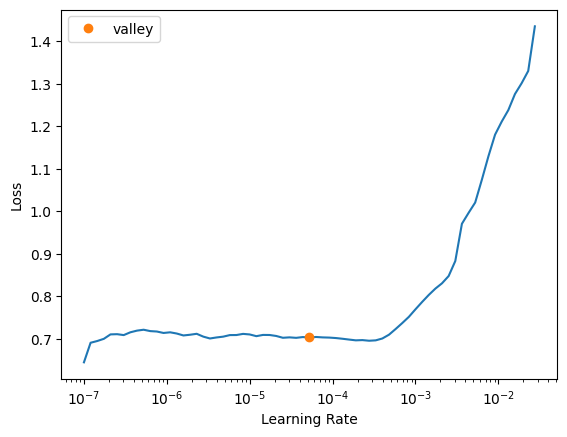

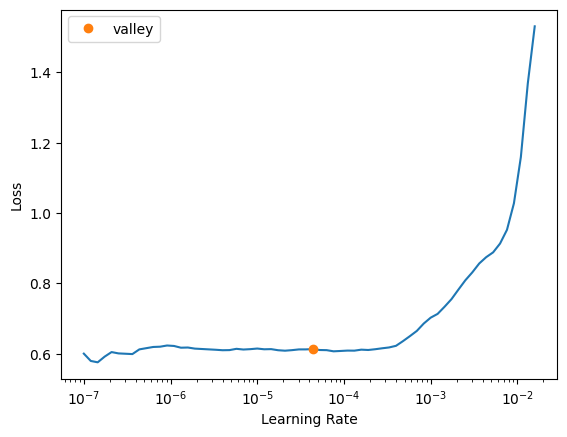

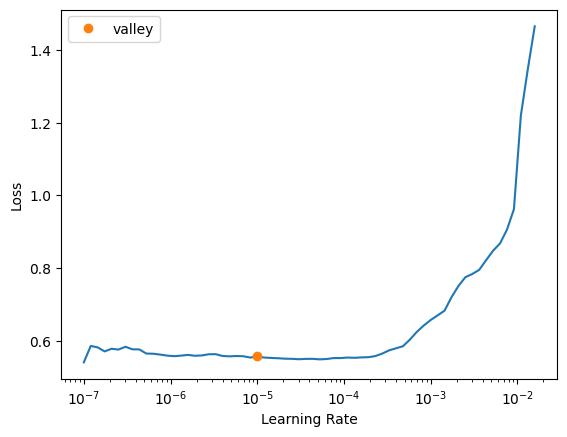

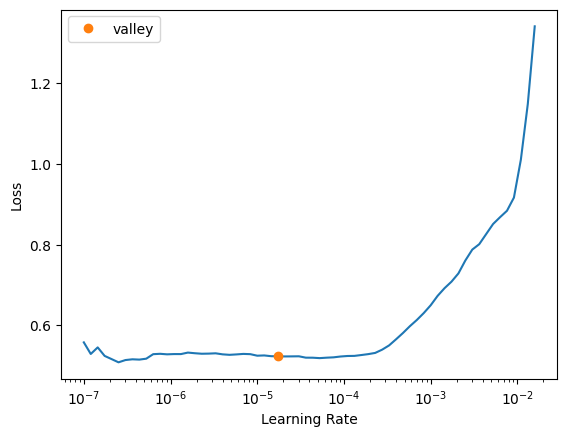

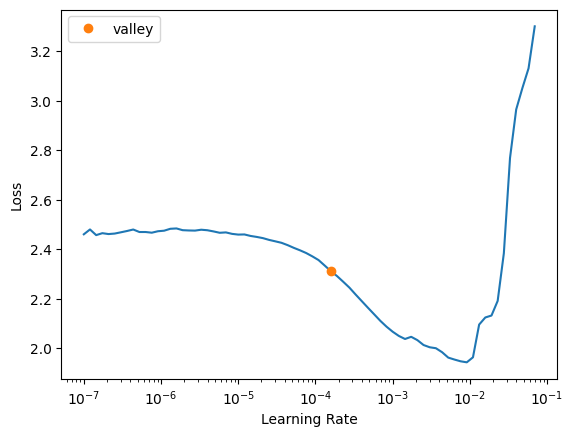

In [11]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'][model], f)

In [18]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for model in models:
  fitness_valid['SHADE-ILS-GD'][model] = []
  for ind in results['SHADE-ILS-GD'][model][3]:
    fitness_valid['SHADE-ILS-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [19]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS-GD for {model} model: {results['SHADE-ILS-GD'][model][2]}")
  print(f"Validation error of SHADE-ILS-GD for {model} model: {fitness_valid['SHADE-ILS-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][model]) - np.array(results['SHADE-ILS-GD'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][model])
  best['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for LeNet5 model: [2.4844369888305664, 0.39558133482933044, 0.38405120372772217, 0.3806741237640381, 0.37929609417915344, 0.37929609417915344, 0.3265696167945862, 0.3252192735671997, 0.3161858022212982, 0.25345808267593384, 0.22473835945129395, 0.22371409833431244, 0.2236323058605194, 0.22130019962787628, 0.22130019962787628, 0.22130019962787628, 0.22130019962787628, 0.22130019962787628, 0.22130019962787628, 0.210629403591156, 0.210629403591156]
Validation error of SHADE-ILS-GD for LeNet5 model: [2.295497417449951, 1.7966389656066895, 1.79892098903656, 1.8028290271759033, 1.7964767217636108, 1.7964767217636108, 1.6130585670471191, 1.6820569038391113, 1.667253017425537, 1.684267520904541, 1.661956548690796, 1.6672738790512085, 1.685190200805664, 1.6643232107162476, 1.6643232107162476, 1.6643232107162476, 1.6643232107162476, 1.6643232107162476, 1.6643232107162476, 3.2875888347625732, 3.2875888347625732]
Difference: [-0.18893957  1.40105763  1.41486979  1.42

### Save or load

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [20]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for model in models:
  training['SHADE'][model] = results['SHADE'][model][6]
  training['SHADE-ILS'][model] = results['SHADE-ILS'][model][2]
  training['SHADE-GD'][model] = results['SHADE-GD'][model][2]
  training['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][2]

In [21]:
from fastai.metrics import accuracy
#Calculate accuracy and accuracy
acc = {}
for mh in algs:
  acc[mh] = {}
  for model in models:
    acc[mh][model] = []
    ind = 5 if mh == 'SHADE' else 3
    start = time.perf_counter()
    for ind in results[mh][model][ind]:
      utilsTFG.set_params_to_model(ind, mh_learners[model].model)
      mh_learners[model].model.eval()
      mh_learners[model].eval()
      preds, targs = mh_learners[model].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      acc[mh][model].append(accuracy(preds, targs))
    end = time.perf_counter()
    #time_full_mh[mh][model]+= end-start

<Figure size 1200x600 with 0 Axes>

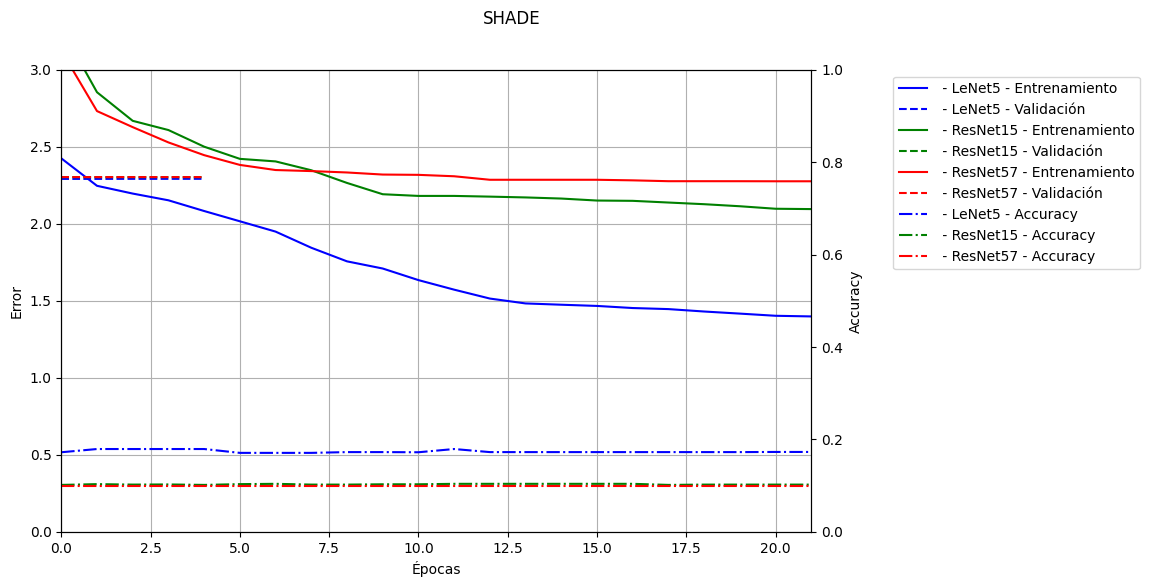

<Figure size 1200x600 with 0 Axes>

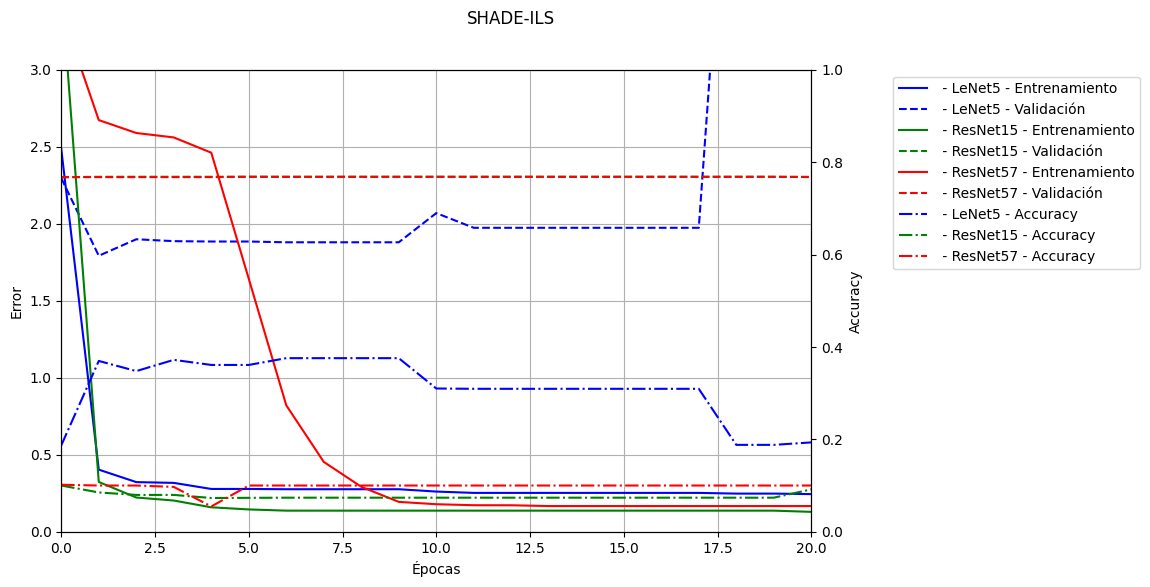

<Figure size 1200x600 with 0 Axes>

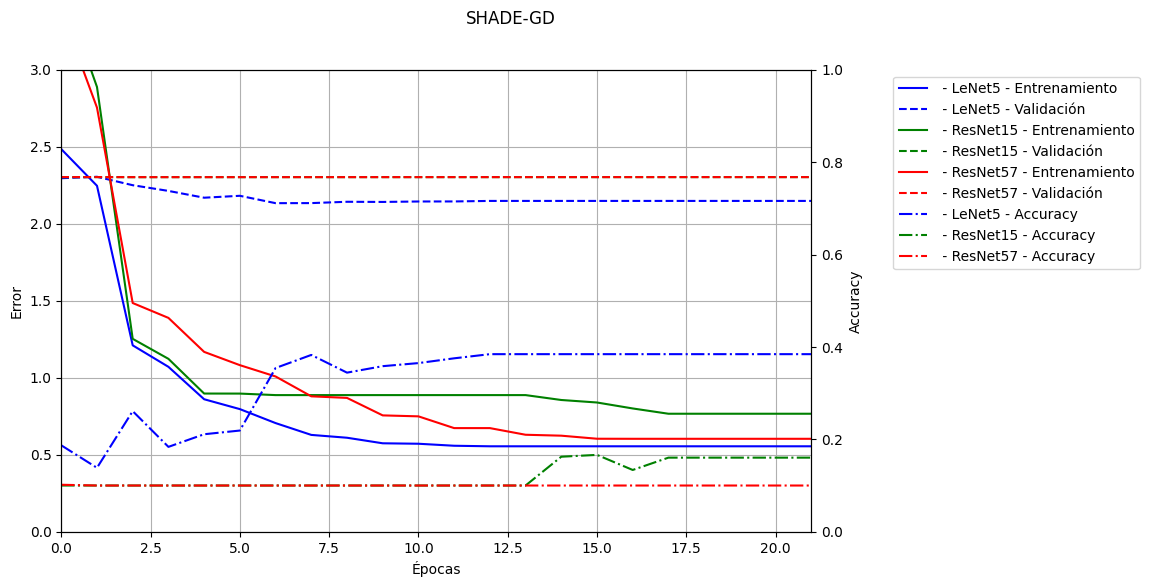

<Figure size 1200x600 with 0 Axes>

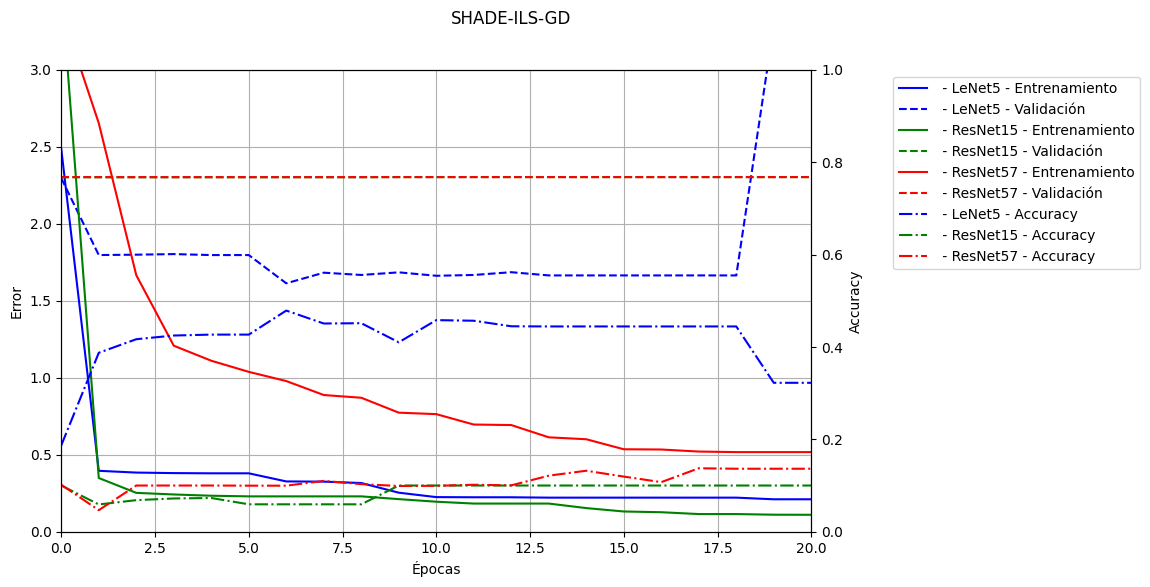

In [22]:
#Comparing the different layers version of the same MH
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], acc[alg], lim = 3, layers=models, names=models, title=f'{alg}', metric='accuracy')

<Figure size 1200x600 with 0 Axes>

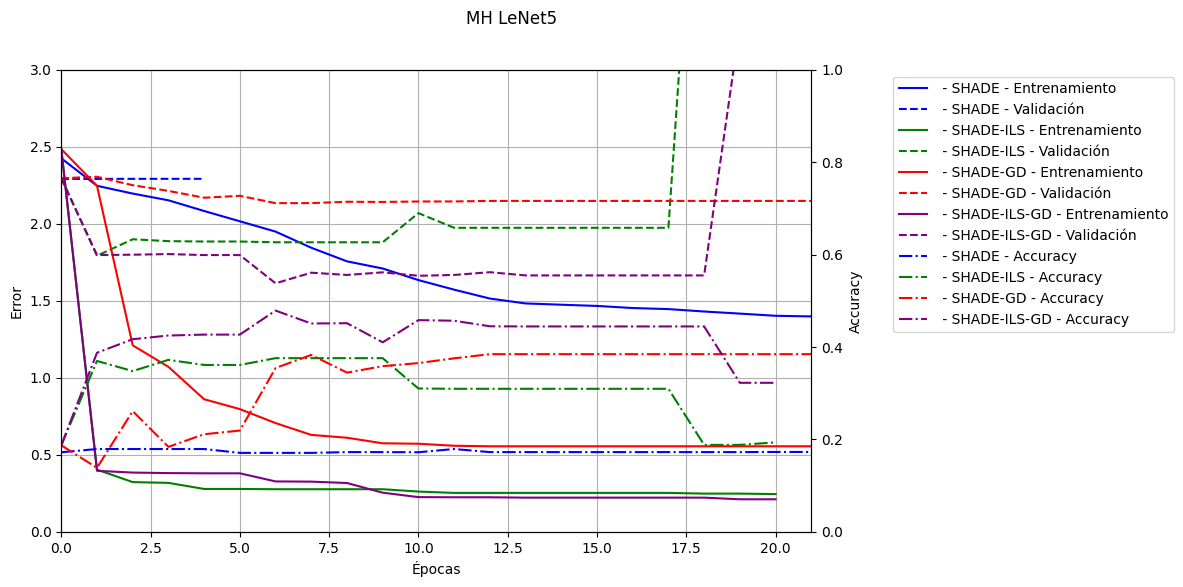

<Figure size 1200x600 with 0 Axes>

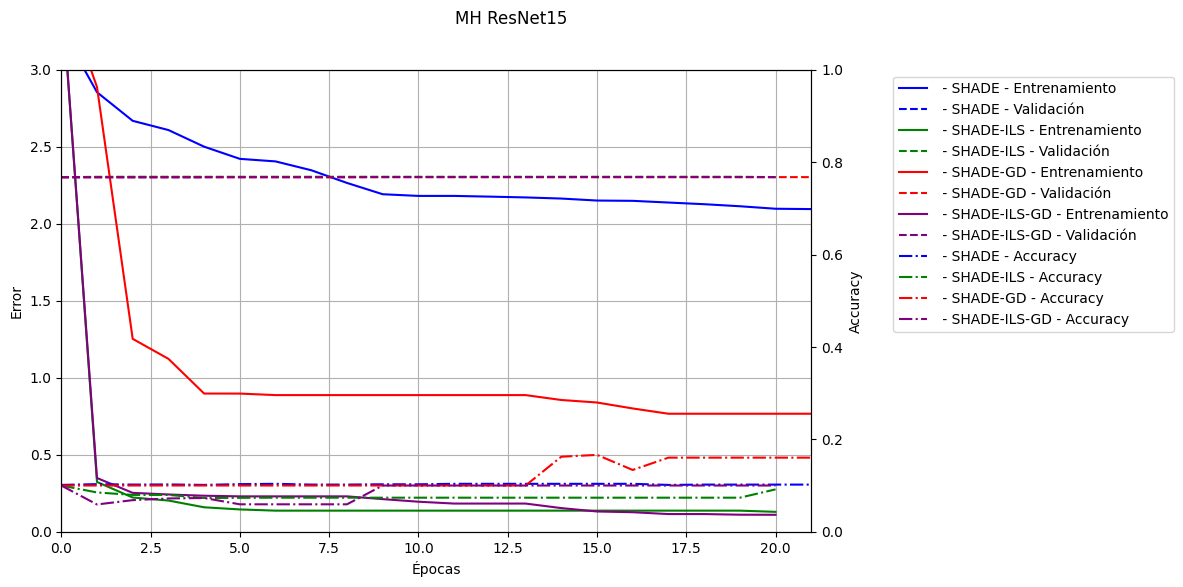

<Figure size 1200x600 with 0 Axes>

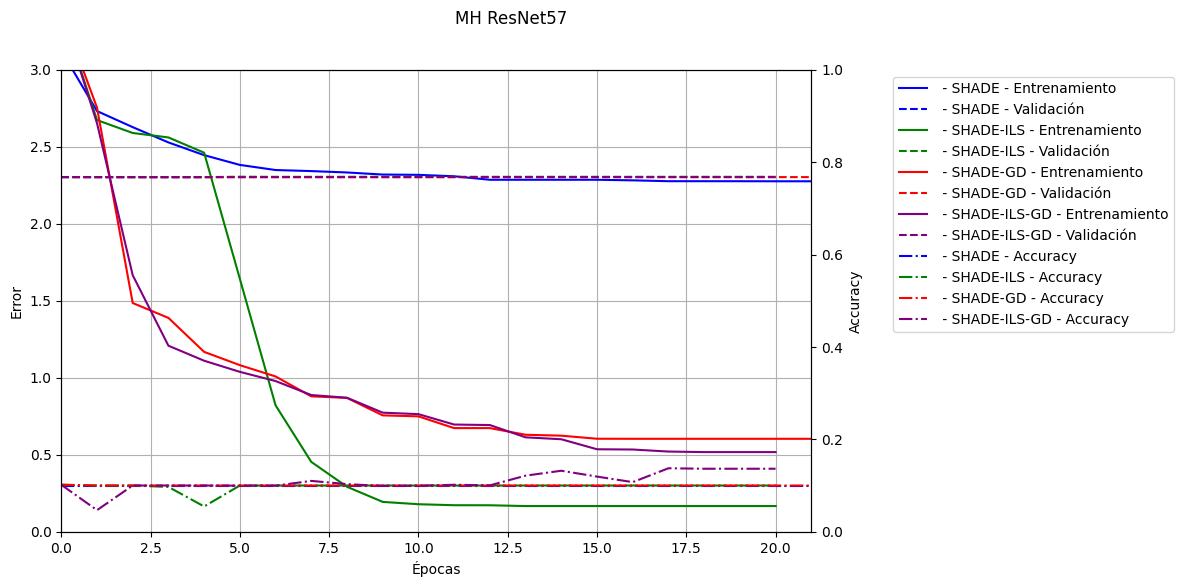

In [23]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
ac = {}
valid = {}
for model in models:
  train[model] = {}
  ac[model] = {}
  valid[model] = {}
  for alg in algs:
    train[model][alg] = training[alg][model]
    ac[model][alg] = acc[alg][model]
    valid[model][alg] = fitness_valid[alg][model]
  utilsTFG.plot_mh_mlp_training(train[model], valid[model], ac[model], lim = 3, layers=names, names=names, title=f'MH {model}', metric='accuracy')

### Generalization

In [27]:
#Run the model in the test set
for mh in algs:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][model], mh_learners[model].model)
    mh_learners[model].model.eval()
    mh_learners[model].eval()
    preds, targs = mh_learners[model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate accuracy

    accur = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[model].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Model: {model}, Loss: {loss}, Accuracy: {accur}")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE, Model: LeNet5, Loss: 2.291128635406494, Accuracy: 0.17980000000000002


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE, Model: ResNet15, Loss: 2.3025920391082764, Accuracy: 0.1044


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE, Model: ResNet57, Loss: 2.3027961254119873, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS, Model: LeNet5, Loss: 1.807236671447754, Accuracy: 0.3658


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS, Model: ResNet15, Loss: 2.3022642135620117, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS, Model: ResNet57, Loss: 2.302615165710449, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-GD, Model: LeNet5, Loss: 2.1395013332366943, Accuracy: 0.3604


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-GD, Model: ResNet15, Loss: 2.3022642135620117, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-GD, Model: ResNet57, Loss: 2.302716016769409, Accuracy: 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS-GD, Model: LeNet5, Loss: 1.6461635828018188, Accuracy: 0.46180000000000004


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS-GD, Model: ResNet15, Loss: 2.3018290996551514, Accuracy: 0.0626


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Optimizer: SHADE-ILS-GD, Model: ResNet57, Loss: 2.302579879760742, Accuracy: 0.1


## Time comparison

In [28]:
#Compare times for each algorithm and layer

#GD
for alg, time_model in time_mh.items():
  for model, time in time_model.items():
    print(f'Time consumed by {alg} training with {model}: {time:.04f} seconds')

#MH
for optims, time_model in time_gd.items():
  for model, time in time_model.items():
    print(f'Time consumed by {optims} training with {model}: {time:.04f} seconds')



Time consumed by SHADE training with LeNet5: 6699.6224 seconds
Time consumed by SHADE training with ResNet15: 7233.4253 seconds
Time consumed by SHADE training with ResNet57: 8499.6879 seconds
Time consumed by SHADE-ILS training with LeNet5: 5999.5790 seconds
Time consumed by SHADE-ILS training with ResNet15: 6668.3456 seconds
Time consumed by SHADE-ILS training with ResNet57: 10846.3372 seconds
Time consumed by SHADE-GD training with LeNet5: 6466.7969 seconds
Time consumed by SHADE-GD training with ResNet15: 7028.4158 seconds
Time consumed by SHADE-GD training with ResNet57: 10474.4369 seconds
Time consumed by SHADE-ILS-GD training with LeNet5: 6641.3552 seconds
Time consumed by SHADE-ILS-GD training with ResNet15: 7238.6578 seconds
Time consumed by SHADE-ILS-GD training with ResNet57: 8900.8661 seconds
Time consumed by NAG training with LeNet5: 59.7403 seconds
Time consumed by NAG training with ResNet15: 61.1019 seconds
Time consumed by NAG training with ResNet57: 74.4803 seconds
Tim

In [ ]:
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')